In [ ]:
# ---------------------------------------------------------
# Useful packages to run the notebook 
# ---------------------------------------------------------
# !pip install fiftyone torch torchvision matplotlib scikit-learn umap-learn anywidget seaborn hugginfacehub

# Part 1: Supervised Fine-Tuning with LeNet-5 and Dataset Curation with FiftyOne

In the first part of this notebook, we explore a traditional approach: **supervised fine-tuning with a convolutional neural network (CNN)**. We will build and train a LeNet-5 model from scratch on the MNIST training data. This will allow us to compare the performance of a task-specific supervised model. Think of it as evaluating the knowledge of a super-specialized expert on a narrow subject matter.

Furthermore, we will leverage the insights gained from our initial data exploration and model evaluation to demonstrate an **iterative dataset curation workflow**. Using FiftyOne's capabilities, we will identify misclassified samples, analyze model uncertainty and mistakenness.

This first part will cover:

- Building and training a LeNet-5 model in PyTorch.
- Evaluating the LeNet-5 model's performance on the test set.
- Analyzing model predictions to identify problematic samples.
- Using FiftyOne to find mislabeled and hard samples in the training data.
- Extracting the intermediate representations learnt by the LeNet-5 model.
- Visualizing the learned embeddings in 2D via PCA and/or UMAP inside FiftyOne.
- Identifying unique and representative samples in the dataset through FiftyOne’s data-mining tools.

## Initial Setup

In [2]:
import os
os.environ["FIFTYONE_DISABLE_NOTEBOOK_APP"] = "1"

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
import fiftyone.utils.eval as foue
import fiftyone.utils.random as four # For splitting
from tqdm import tqdm # For progress bars
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Try importing cv2 to set its seed, handle gracefully if not installed
try:
    import cv2
except ImportError:
    cv2 = None

## Reproducibility

To ensure full reproducibility of your training experiments, we set random seeds for all libraries and operations that involve randomness. This ensures that initial model weights, data shuffling, and any other random operations are the same across different runs.


In [3]:
# ---------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.
    Matches strict deterministic requirements.
    """
    # Set environment variables for deterministic behavior
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Required for some CUDA operations to be deterministic
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 

    random.seed(seed) # Python random
    np.random.seed(seed)     # NumPy
    torch.manual_seed(seed)     # PyTorch
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU
        
        # CUDA deterministic settings
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    # OpenCV (if available)
    if cv2 is not None:
        cv2.setRNGSeed(seed)

    # Enforce deterministic algorithms in PyTorch
    # This raises errors if a specific operation doesn't have a deterministic implementation
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError as e:
        print(f"Note: Deterministic algorithms warning: {e}")
        print("Continuing with best-effort reproducibility.")
    print(f"--- All random seeds set to {seed} ---")

def create_deterministic_training_dataloader(dataset, batch_size, seed=51, shuffle=True, **kwargs):
    """
    Create a DataLoader with a fixed generator for reproducible shuffling.
    """
    generator = None
    if shuffle:
        generator = torch.Generator()
        generator.manual_seed(seed)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator,
        **kwargs
    )

# Apply setup
set_seeds(51)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

--- All random seeds set to 51 ---
Using device: cuda


## Download \& Preprocessing of the MNIST Training Dataset from FiftyOne's Zoo

To train our supervised model, we need the training split of the MNIST dataset. FiftyOne's Dataset Zoo provides a convenient way to load this data. We will load the training split and make it persistent so that any changes we make to the dataset (like adding tags or embeddings) are saved across sessions.

### Data Loading & Splitting (Train/Val)

Loads the dataset, cleans old tags, and creates a reproducible 85/15 split.

In [4]:
# Load MNIST via FiftyOne
train_val_dataset = foz.load_zoo_dataset("mnist", split='train', dataset_name="mnist-curation-lab-tv", persistent=True)
test_dataset = foz.load_zoo_dataset("mnist", split='test', dataset_name="mnist-curation-lab-test", persistent=True)

# Untag existing to ensure clean slate
train_val_dataset.untag_samples(["train", "validation"])

# Create random 85%/15% split using tags
four.random_split(
    train_val_dataset,
    {"train": 0.85, "validation": 0.15},
    seed=51
)

# Verify the split
print("Tag counts after split:", train_val_dataset.count_sample_tags())

# Separate into Views and Clone
# Delete datasets if they already exist to avoid naming collisions 
for name in ["mnist-training-set", "mnist-validation-set", "mnist-test-set"]:
    if name in fo.list_datasets():
        print(f"Deleting existing dataset: {name}")
        fo.delete_dataset(name)

# Now it is safe to clone
train_dataset = train_val_dataset.match_tags("train").clone("mnist-training-set")
val_dataset = train_val_dataset.match_tags("validation").clone("mnist-validation-set")
test_dataset = test_dataset.clone("mnist-test-set")

train_dataset.persistent = True
val_dataset.persistent = True
test_dataset.persistent = True

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

Split 'train' already downloaded


Loading existing dataset 'mnist-curation-lab-tv'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Split 'test' already downloaded
Loading existing dataset 'mnist-curation-lab-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Tag counts after split: {'validation': 9000, 'train': 51000}
Deleting existing dataset: mnist-training-set
Deleting existing dataset: mnist-validation-set
Deleting existing dataset: mnist-test-set
Train samples: 51000
Val samples:   9000
Test samples:  10000


### Statistics Computation & Normalization
Manually computes Mean/Std of our input data to apply **standard scaling** (also called normalization or standardization),

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ = standardized value
- $x$ = original pixel value
- $\mu$ = mean of all pixel values in the dataset
- $\sigma$ = standard deviation of all pixel values in the dataset

**Why Standard Scaling Matters:**

**Gradient Optimization**: Neural networks learn through gradient descent, which works best when input features are on similar scales. Without scaling, features with larger magnitudes (like raw pixel values 0-255) can dominate the gradient updates, leading to slower convergence and unstable training.

**Weight Initialization Compatibility**: Modern weight initialization schemes (Xavier, He initialization) assume inputs are roughly centered around zero with unit variance. Standard scaling ensures our data matches these assumptions, preventing vanishing or exploding gradients during early training.

**Activation Function Efficiency**: Many activation functions (tanh, sigmoid) work optimally when inputs are centered around zero. Scaled inputs help neurons operate in the most responsive regions of these functions rather than saturating in flat regions.

**Learning Rate Stability**: With standardized inputs, we can use higher learning rates without instability, as the optimization landscape becomes more uniform across different dimensions.

For MNIST images, we transform raw pixel values from the range [0, 255] to approximately [-1, 1] with mean ≈ 0, creating a more favorable training environment that typically results in faster convergence and better final performance.

In [5]:
def compute_stats_fiftyone(fiftyone_view):
    """Compute stats directly from FiftyOne images."""
    print("Computing image intensity statistics...")
    filepaths = fiftyone_view.values("filepath")
    all_pixels = []

    # We use a subset or full set. For MNIST, full set is fast enough.
    for filepath in tqdm(filepaths):
        try:
            img = Image.open(filepath).convert('L')
            pixels = np.array(img, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            continue

    all_pixels = np.concatenate(all_pixels)
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)
    return mean, std

# Compute stats on training set only
mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
print(f"\nComputed Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}")

# Define Transforms based on computed stats
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

Computing image intensity statistics...


100%|██████████| 51000/51000 [00:05<00:00, 9814.32it/s]



Computed Mean: 0.1318, Std: 0.3075


### PyTorch Dataset Wrapper & DataLoaders

We use a custom class and deterministic loader creator.

In [6]:
# ---------------------------------------------------------
# Torch Dataset Wrapper
# ---------------------------------------------------------
class CustomTorchImageDataset(Dataset):
    def __init__(self, fiftyone_dataset, image_transforms=None, label_map=None, gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms
        
        # Create default label map if not provided
        if label_map is None:
            classes = sorted(list(set(self.str_labels)))
            self.label_map = {cls: i for i, cls in enumerate(classes)}
        else:
            self.label_map = label_map

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('L')
        except Exception:
            # Fallback for corrupt images (though MNIST is usually clean)
            return torch.zeros(1, 28, 28), torch.tensor(-1)

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        
        return image, torch.tensor(label_idx, dtype=torch.long)

In [7]:
# Define Label Map (0-9)
dataset_classes = sorted(train_dataset.distinct("ground_truth.label"))
label_map = {k: v for v, k in enumerate(dataset_classes)}

# Instantiate Datasets
torch_train_set = CustomTorchImageDataset(train_dataset, label_map=label_map, image_transforms=image_transforms)
torch_val_set = CustomTorchImageDataset(val_dataset, label_map=label_map, image_transforms=image_transforms)
torch_test_set = CustomTorchImageDataset(test_dataset, label_map=label_map, image_transforms=image_transforms)

# Create DataLoaders
num_workers = 2 # Adjust based on environment
batch_size = 64

train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=batch_size,
    seed=51,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    torch_test_set,
    batch_size=1000,
    shuffle=False,
    num_workers=num_workers
)

print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.


## Creation of a Custom Convolutional Neural Networks in PyTorch (Modern Version of LeNet-5)

LeNet-5's architecture is elegantly simple yet effective: it uses alternating convolutional and pooling layers to extract hierarchical features, followed by fully connected layers for classification. The network learns low-level features like edges and curves in early layers, then combines these into higher-level digit patterns in deeper layers. This hierarchical feature learning principle underlies virtually all modern CNN architectures.
Below is an alternative and more modern implementation. Here the activation functions have been switched from tanh to ReLU and Max Pooling is used instead of Average Pooling. 

In [8]:
class ModernLeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.5)

        # Placeholder for embeddings extraction
        self.embeddings_hook = None
        self.current_embeddings = []

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        
        # Hook point: The 120->84 layer contains rich semantic features
        if self.embeddings_hook:
            # We will register hook on fc1 externally, or we can capture x here
            pass
            
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Training and Validation of Our Custom LeNet5

1. We define two functions to handle the training and validation phases of each epoch. The `train_epoch()` function puts the model in training mode, processes batches through forward passes, computes loss, and updates weights via backpropagation. The `val_epoch()` function switches the model to evaluation mode and computes validation loss without updating weights, giving us an unbiased measure of performance on held-out data. These functions return the average loss across all batches, which we'll track to monitor training progress and detect overfitting.

2. We define a post-training function to perform inference, store the predictions (with logit) in FiftyOne, and optionally store the embeddings.

3. We define a visualization function for training and validation loss, to identify the best validation epoch to prevent overfitting.

3. We instantiate: 
    - the optimizer as **Adam (Adaptive Moment Estimation)**, a variant of gradient descent that maintains running averages of both gradients and their squared values, allowing us to adapt the learning rate based on the historical behavior of each weight,
        ```python
        optimizer = Adam(model.parameters(),
                        lr=0.003, betas=(0.9, 0.999),
                        eps=1e-08, weight_decay=0)
        ```

        The learning rate (lr=0.003) controls the step size for weight updates, while the beta settings control how much history to consider when computing the adaptive rates. This configuration provides stable training for most computer vision tasks.
    - the loss as **Categorical Cross Entropy**, the standard loss function for multi-class classification problems like MNIST digit recognition. It measures how far our model's predicted probability distribution is from the true distribution (one-hot encoded labels). The loss encourages the model to output high confidence (probability close to 1.0) for the correct class and low confidence for incorrect classes,

        $$\text{CCE} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

        where:
        - $C$ = number of classes (10 for MNIST digits 0-9)
        - $y_i$ = true label (1 for correct class, 0 for others)
        - $\hat{y}_i$ = predicted probability for class $i$

4. During training, we validate the model at each epoch and save checkpoints corresponding to the lowest validation loss. After training, we reload the best-performing model, move it to the appropriate device, switch it to evaluation mode, and assess the results using FiftyOne metrics and visualizations through our custom function.

In [9]:
# ---------------------------------------------------------
# Training and Evaluation Helpers
# ---------------------------------------------------------
# Epoch Training Loop
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    batch_losses = []
    
    for data, target in tqdm(loader, desc="Training", leave=False):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data) # Logits
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        
    return np.mean(batch_losses)

# Epoch Validation Loop
def val_epoch(model, loader, criterion):
    model.eval()
    batch_losses = []
    
    with torch.inference_mode(): # More efficient than no_grad
        for data, target in tqdm(loader, desc="Validation", leave=False):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            batch_losses.append(loss.item())
            
    return np.mean(batch_losses)
    
# Visualization Function
def plot_training_validation_loss(train_losses, val_losses, title=None):
    plt.figure(figsize=(8, 5))
    
    # Plot training and validation losses
    plt.plot(train_losses, 
             linewidth=1, marker='o', markersize=15, 
             color="#87b7eb", markerfacecolor="#87b7eb", 
             markeredgecolor="#33608e", markeredgewidth=2, 
             label="Training Loss")
    
    plt.plot(val_losses, 
             linewidth=1, marker='o', markersize=15, 
             color="#ce717f", markerfacecolor="#ce717f", 
             markeredgecolor="#c8243c", markeredgewidth=2,
             label="Validation Loss")
    
    # Customize axes
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#383838')
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('#383838')
    ax.spines['bottom'].set_linewidth(2.5)
    
    # Customize tick lines
    ax.tick_params(axis='x', length=8)
    ax.tick_params(axis='y', length=8)
    
    # Customize tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(14)
        label.set_color('#383838')
    
    # Best validation loss epoch
    best_epoch = np.argmin(val_losses)
    
    # Vertical line at best validation epoch
    plt.axvline(x=best_epoch, color='#383838', linestyle='-', linewidth=2)
    
    # Rotated text label
    plt.text(
        best_epoch, 
        np.max(train_losses) - 0.08, 
        'Best Val Epoch', 
        rotation=90, 
        color='#383838', 
        fontsize=14,
        verticalalignment='bottom', 
        horizontalalignment='right'
    )
    
    # Legend
    plt.legend(loc='best', fontsize=16)
    
    # Labels and title
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    if title:
        plt.title(title, fontsize=18, loc='right')
    
    plt.show()

/home/vanessa/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 Quadro P400 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/vanessa/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/vanessa/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:326: UserWarning: 
Quadro P400 with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the Quadro P400 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings

--- All random seeds set to 51 ---
Starting training for 10 epochs...
Model will be saved to: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/checkpoints/best_lenet.pth


Epoch 1/10 | Train Loss: 0.2186 | Val Loss: 0.0824
  --> Found better weights. Saved.


Epoch 2/10 | Train Loss: 0.0803 | Val Loss: 0.0534
  --> Found better weights. Saved.


Epoch 3/10 | Train Loss: 0.0615 | Val Loss: 0.0699


Epoch 4/10 | Train Loss: 0.0503 | Val Loss: 0.0709


Epoch 5/10 | Train Loss: 0.0467 | Val Loss: 0.0466
  --> Found better weights. Saved.


Epoch 6/10 | Train Loss: 0.0445 | Val Loss: 0.0794


Epoch 7/10 | Train Loss: 0.0391 | Val Loss: 0.0542


Epoch 8/10 | Train Loss: 0.0360 | Val Loss: 0.0621


Epoch 9/10 | Train Loss: 0.0363 | Val Loss: 0.1074


Epoch 10/10 | Train Loss: 0.0366 | Val Loss: 0.0586


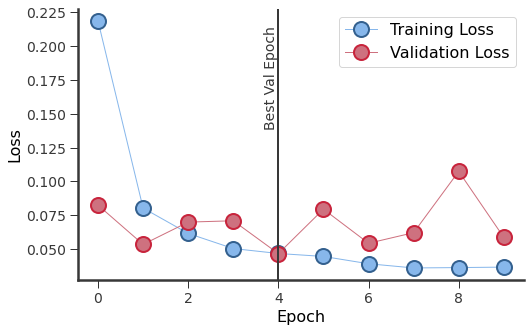


Loading best model for curation analysis...
Model loaded successfully from /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/checkpoints/best_lenet.pth
Model is on device: cuda:0


In [10]:
# --- Setup ---
set_seeds(51)
model = ModernLeNet5(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

num_epochs = 10 # increase if needed
train_losses = []
val_losses = []

best_val_loss = float('inf')
path = os.path.join(Path(os.getcwd()), 'checkpoints')
os.makedirs(path, exist_ok=True)
model_save_path = f'{path}/best_lenet.pth'

print(f"Starting training for {num_epochs} epochs...")
print(f"Model will be saved to: {model_save_path}")

# --- Training Loop ---
for epoch in range(num_epochs):
    t_loss = train_epoch(model, train_loader, optimizer, criterion)
    v_loss = val_epoch(model, val_loader, criterion)
    
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f}")
    
    # Save Best Model
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"  --> Found better weights. Saved.")
    
plot_training_validation_loss(train_losses, val_losses) #title="LeNet5 Training and Validation Loss"

# --- Final Evaluation on Training Data (for Curation) ---
print("\nLoading best model for curation analysis...")
model.load_state_dict(torch.load(model_save_path))
model.to(device)

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(model.parameters()).device}")

## Summary of Prediction Storage, Evaluation, and Hardness/Mistakenness Metrics

After training our custom LeNet-5 model, we apply it to the test set and store its outputs as FiftyOne `Classification` objects. This structured format includes the predicted label, confidence score, and raw logits, allowing seamless integration with FiftyOne’s visualization, querying, and evaluation tools. With this representation, we can filter samples by confidence, identify misclassifications, compare multiple models, and visualize prediction behavior directly in the FiftyOne App.

To assess model performance, we use FiftyOne’s `evaluate_classifications()` method, which computes detailed metrics such as per-class precision, recall, F1-scores, and confusion matrices. These metrics provide insight into which digits the model distinguishes well and which it commonly confuses.

Beyond standard evaluation, we leverage the model’s logits to compute two additional diagnostic measures:

- **Hardness**: Quantifies prediction uncertainty. Samples with high hardness have flat or ambiguous logit distributions and represent inherently difficult or ambiguous cases.

- **Mistakenness**: Highlights samples where the model is confident yet disagrees with the ground-truth label. High mistakenness scores often reveal potential annotation errors rather than model failures.

These metrics allow the creation of targeted views such as low-confidence samples or highly suspicious (high-mistakenness) samples. Together, this workflow transforms raw model predictions into actionable insights that illuminate model behavior, dataset quality, and areas for further improvement.

In [11]:
from fiftyone import ViewField as VF

class MNISTEvaluator:
    def __init__(self, model, device, label_map):
        self.model = model
        self.device = device
        self.label_map = label_map
        self.idx_to_class = {v: k for k, v in label_map.items()}

    def predict_and_store(self, fo_dataset, torch_dataset, pred_field="model_pred", batch_size=64):
        """Runs inference and stores predictions + logits."""
        print(f"--- Inference on {fo_dataset.name} ---")
        self.model.eval()
        loader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        predictions, confidences, logits_list = [], [], []
        
        with torch.inference_mode():
            for data, _ in tqdm(loader, desc="Inference", leave=False):
                data = data.to(self.device)
                logits = self.model(data)
                
                probs = F.softmax(logits, dim=1)
                conf, preds = torch.max(probs, 1)
                batch_logits = logits.cpu().numpy()
                
                for i in range(len(preds)):
                    lbl_idx = preds[i].item()
                    predictions.append(self.idx_to_class[lbl_idx])
                    confidences.append(conf[i].item())
                    logits_list.append(batch_logits[i].tolist())

        classifications = [
            fo.Classification(label=p, confidence=c, logits=l) 
            for p, c, l in zip(predictions, confidences, logits_list)
        ]
        fo_dataset.set_values(pred_field, classifications)
        print(f"Stored results in '{pred_field}'.")

    def compute_brain_metrics(self, fo_dataset, pred_field, gt_field="ground_truth"):
        """Computes Hardness and Mistakenness."""
        print(f"--- Computing Brain Metrics for {fo_dataset.name} ---")
        fob.compute_hardness(fo_dataset, label_field=pred_field)
        fob.compute_mistakenness(fo_dataset, pred_field=pred_field, label_field=gt_field)

    def create_low_confidence_view(self, fo_dataset, pred_field, threshold=0.69, save_name="low_confidence"):
        """
        Filters samples with confidence below threshold and SAVES the view.
        """
        if fo_dataset.has_saved_view(save_name):
            print(f"View '{save_name}' already exists. Skipping creation.")
            return fo_dataset.load_saved_view(save_name)
        
        print(f"Creating Low Confidence View (< {threshold})...")
        view = fo_dataset.match(VF(f"{pred_field}.confidence") < threshold)
        
        # SAVE the view to the dataset so it appears in the App
        fo_dataset.save_view(save_name, view)
        print(f"Saved view '{save_name}' with {len(view)} samples.")
        return view

    def create_suspicious_view(self, fo_dataset, q_percentile=0.99, save_name="suspicious_mistakes"):
        """
        Finds top percentile of mistakenness and SAVES the view.
        """
        if fo_dataset.has_saved_view(save_name):
            print(f"View '{save_name}' already exists. Skipping creation.")
            return fo_dataset.load_saved_view(save_name)

        print(f"Creating Suspicious View (Top {1-q_percentile:.2%} mistakenness)...")
        # Calculate the value at the requested quantile (e.g., 0.99)
        thresh = fo_dataset.quantiles("mistakenness", [q_percentile])[0]
        
        view = fo_dataset.match(
            VF("mistakenness") > thresh
        ).sort_by("mistakenness", reverse=True)
        
        # SAVE the view
        fo_dataset.save_view(save_name, view)
        print(f"Saved view '{save_name}' with {len(view)} samples.")
        return view
    
    def extract_and_store_embeddings(self, fo_dataset, torch_dataset, layer_name='fc1', batch_size=64):
        """
        Extracts embeddings using a hook and stores them in the dataset.
        In the case of LeNet-5, for example, the hook on the FC1 layer extracts pre-ReLU, unclipped feature representations before the activation function renders them zero. 
        """
        print(f"--- Extracting Embeddings from '{layer_name}' on {fo_dataset.name} ---")
        
        # Setup Hook
        embeddings_dict = {}
        def hook_fn(module, input, output):
            if len(output.shape) > 2:
                embeddings_dict['emb'] = output.view(output.size(0), -1).detach()
            else:
                embeddings_dict['emb'] = output.detach()

        target_layer = getattr(self.model, layer_name)
        hook_handle = target_layer.register_forward_hook(hook_fn)

        # Inference (No Shuffle is CRITICAL or we won't be able to reatin predictions per sample !)
        self.model.eval()
        loader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        all_embeddings = []
        
        with torch.inference_mode():
            for data, _ in tqdm(loader, desc="Extracting"):
                data = data.to(self.device)
                _ = self.model(data) # Forward pass triggers hook
                all_embeddings.append(embeddings_dict['emb'].cpu().numpy())

        hook_handle.remove()
        
        # Concatenate and Store
        final_embeddings = np.concatenate(all_embeddings, axis=0)
        print(f"Embedding Shape: {final_embeddings.shape}")
        
        fo_dataset.set_values("lenet_embeddings", final_embeddings)
        print("Embeddings stored in 'lenet_embeddings'.")
        return final_embeddings

    def compute_similarity_index(self, fo_dataset):
        """Computes Similarity, Uniqueness, and Representativeness."""
        print(f"--- Computing Similarity Index & Metrics on {fo_dataset.name} ---")
        
        # Similarity Index
        fob.compute_similarity(
            fo_dataset,
            embeddings="lenet_embeddings",
            brain_key="lenet_sim_index",
            metric="cosine"
        )
        
        # Uniqueness
        fob.compute_uniqueness(fo_dataset, embeddings="lenet_embeddings")
        
        # Representativeness
        fob.compute_representativeness(fo_dataset, embeddings="lenet_embeddings")
        
        print("Similarity, Uniqueness, and Representativeness computed.")

    def compute_visualizations_2d(self, fo_dataset):
        """Computes PCA and UMAP."""
        print(f"--- Computing 2D Visualizations (PCA/UMAP) on {fo_dataset.name} ---")
        
        fob.compute_visualization(
            fo_dataset,
            embeddings="lenet_embeddings",
            method="pca",
            brain_key="lenet_pca",
            num_dims=2
        )
        
        fob.compute_visualization(
            fo_dataset,
            embeddings="lenet_embeddings",
            method="umap",
            brain_key="lenet_umap",
            num_dims=2
        )
        print("PCA and UMAP computed.")

    def get_extreme_samples(self, fo_dataset, metric="uniqueness", q_percentile=0.999):
        """Returns a view of the top percentile samples for a given metric."""
        thresh = fo_dataset.quantiles(metric, [q_percentile])[0]
        print(f"Finding top {1-q_percentile:.1%} {metric} (Thresh: {thresh:.4f})")
        
        view = fo_dataset.match(VF(metric) > thresh).sort_by(metric, reverse=True)
        return view
    
    def visualize_confusion_matrix(self, fo_dataset, pred_field, gt_field="ground_truth"):
        """Computes and plots a styled confusion matrix."""
        print(f"--- Visualizing Confusion Matrix for {fo_dataset.name} ---")
        
        if pred_field not in fo_dataset.get_field_schema():
            print(f"\nError: Field '{pred_field}' not found in dataset '{fo_dataset.name}'.")
            print(f"    You must run 'evaluator.predict_and_store(dataset, ...)' before visualizing results.\n")
            return
        
        # Run Evaluation using FiftyOne's built-in method
        results = fo_dataset.evaluate_classifications(
            pred_field,
            gt_field=gt_field,
            eval_key=f"eval_cm_{pred_field}",
            method="simple"
        )

        # Extract Data
        cm = results.confusion_matrix()
        raw_labels = results.classes
        
        # Handle label extraction safely (e.g., "0" vs "0 - zero")
        # Uses [-1] to get the last part if "-" exists, or the whole string if it doesn't.
        labels = np.array([l.split("-")[-1].strip() for l in raw_labels])

        # Plotting (Your Custom Style)
        plt.figure(figsize=(7, 6))

        ax = sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="RdBu",   # blue–red palette
            xticklabels=labels,
            yticklabels=labels,
            cbar=True,
            linewidths=0.5,
            linecolor="black"
        )

        # Highlight off-diagonals > 3
        for i, text in enumerate(ax.texts):
            row = i // cm.shape[1]
            col = i % cm.shape[1]
            value = cm[row][col]

            if row != col and value > 3:
                # Highlight: strong color, no transparency
                text.set_color("#dddddd")      # black or choose any strong color
                text.set_fontweight("bold")
                text.set_alpha(1.0)
            else:
                # Normal style (light + semi-transparent)
                text.set_color("#dddddd")
                text.set_alpha(0.4)

            text.set_fontsize(15)
            
        ax.tick_params(left=False, bottom=False)

        # Modify tick label orientation
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15, ha="right", color='#383838')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15, va="top", color='#383838')

        # Modify colorbar tick label font size
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14, color='#383838')

        plt.xlabel("predicted", fontsize=16)
        plt.ylabel("true", fontsize=16)
        plt.tight_layout()
        plt.show()

# Instantiate the Evaluator class
evaluator = MNISTEvaluator(model, device, label_map)

--- Inference on mnist-test-set ---


Stored results in 'lenet_pred'.
--- Visualizing Confusion Matrix for mnist-test-set ---


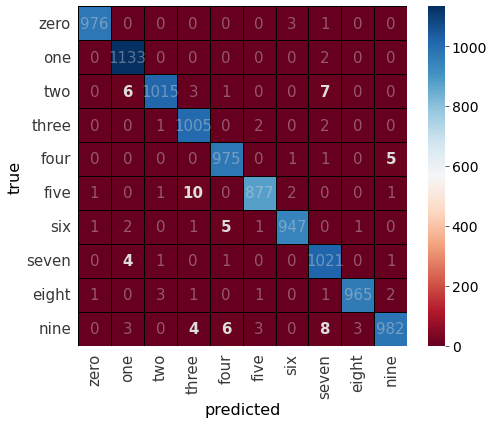

In [12]:
# Inference
evaluator.predict_and_store(test_dataset, torch_test_set, pred_field="lenet_pred")

# Compute Confusion Matrix and Visualize
evaluator.visualize_confusion_matrix(test_dataset, pred_field="lenet_pred", gt_field="ground_truth")

### 📉 Analysis of LeNet Failures

By inspecting the off-diagonal elements (the errors) in the confusion matrix above, we can identify specific patterns where the LeNet model struggles. These non-zero values represent the **"Confusion Pairs"**:

1.  **The "5 vs 3" Confusion (Top Error):**
    *   **Observation:** The single highest error count is **10** instances where a true **5** was predicted as a **3**.
    *   **Hypothesis:** Digits 5 and 3 are morphologically similar, sharing a bottom curve and a top horizontal stroke. If the vertical stroke of the 5 is slanted or short, it closely resembles a 3.

2.  **The "9" Ambiguity:**
    *   **Observation:** The digit **9** is the most "promiscuous" error source. It is frequently confused with **7** (8 errors) and **4** (6 errors).
    *   **Hypothesis:**
        *   **9 vs 7:** A "9" with a straight stem and a weak top loop looks identical to a "7".
        *   **9 vs 4:** An open-top "9" often looks like a "4". This confirms that the **"Spaghetti Nine"** issue mentioned in the tutorial is likely affecting our model here.

3.  **The "2 vs 7" Confusion:**
    *   **Observation:** There are **7** instances where a true **2** was predicted as a **7**.
    *   **Hypothesis:** Sharp-cornered 2s can look like 7s depending on the handwriting style.

---

### 🔮 What to Expect: Hardness & Mistakenness

Based on these visual errors, here is what we expect to find when we compute the FiftyOne Brain metrics in the next step:

#### **1. Expectations for Hardness (Uncertainty)**
*   **Definition:** Hardness measures the entropy of the prediction distribution. High hardness means the model was "unsure" (e.g., 51% confidence vs 49% confidence).
*   **Prediction:** We expect the **5 vs 3** and **9 vs 4** cases to populate the top of the "Hardness" view. These digits likely sit right on the decision boundary in the embedding space, causing the model to output very similar probabilities for both classes.

#### **2. Expectations for Mistakenness (Label Errors)**
*   **Definition:** Mistakenness highlights samples where the model is **confident** but **wrong** relative to the ground truth.
*   **Prediction:**
    *   **Genuine Label Errors:** If a user accidentally labeled a "3" as a "5", the model will confidently predict "3" (correctly), but the system will flag it as high mistakenness because it disagrees with the ground truth.
    *   **Strong Outliers:** We expect to find the **"Spaghetti Nines"** here; digits that look *perfectly* like a 4 visually, but are labeled 9. The model is "right" to think they are 4s based on features, but the label insists they are 9s.

--- Computing Brain Metrics for mnist-test-set ---
Computing hardness...
 100% |█████████████| 10000/10000 [16.6s elapsed, 0s remaining, 599.1 samples/s]      
Hardness computation complete
Computing mistakenness...
 100% |█████████████| 10000/10000 [11.5s elapsed, 0s remaining, 918.2 samples/s]      
Mistakenness computation complete
Creating Low Confidence View (< 0.69)...
Saved view 'test_low_conf' with 114 samples.
Creating Suspicious View (Top 1.00% mistakenness)...
Saved view 'test_suspicious' with 100 samples.



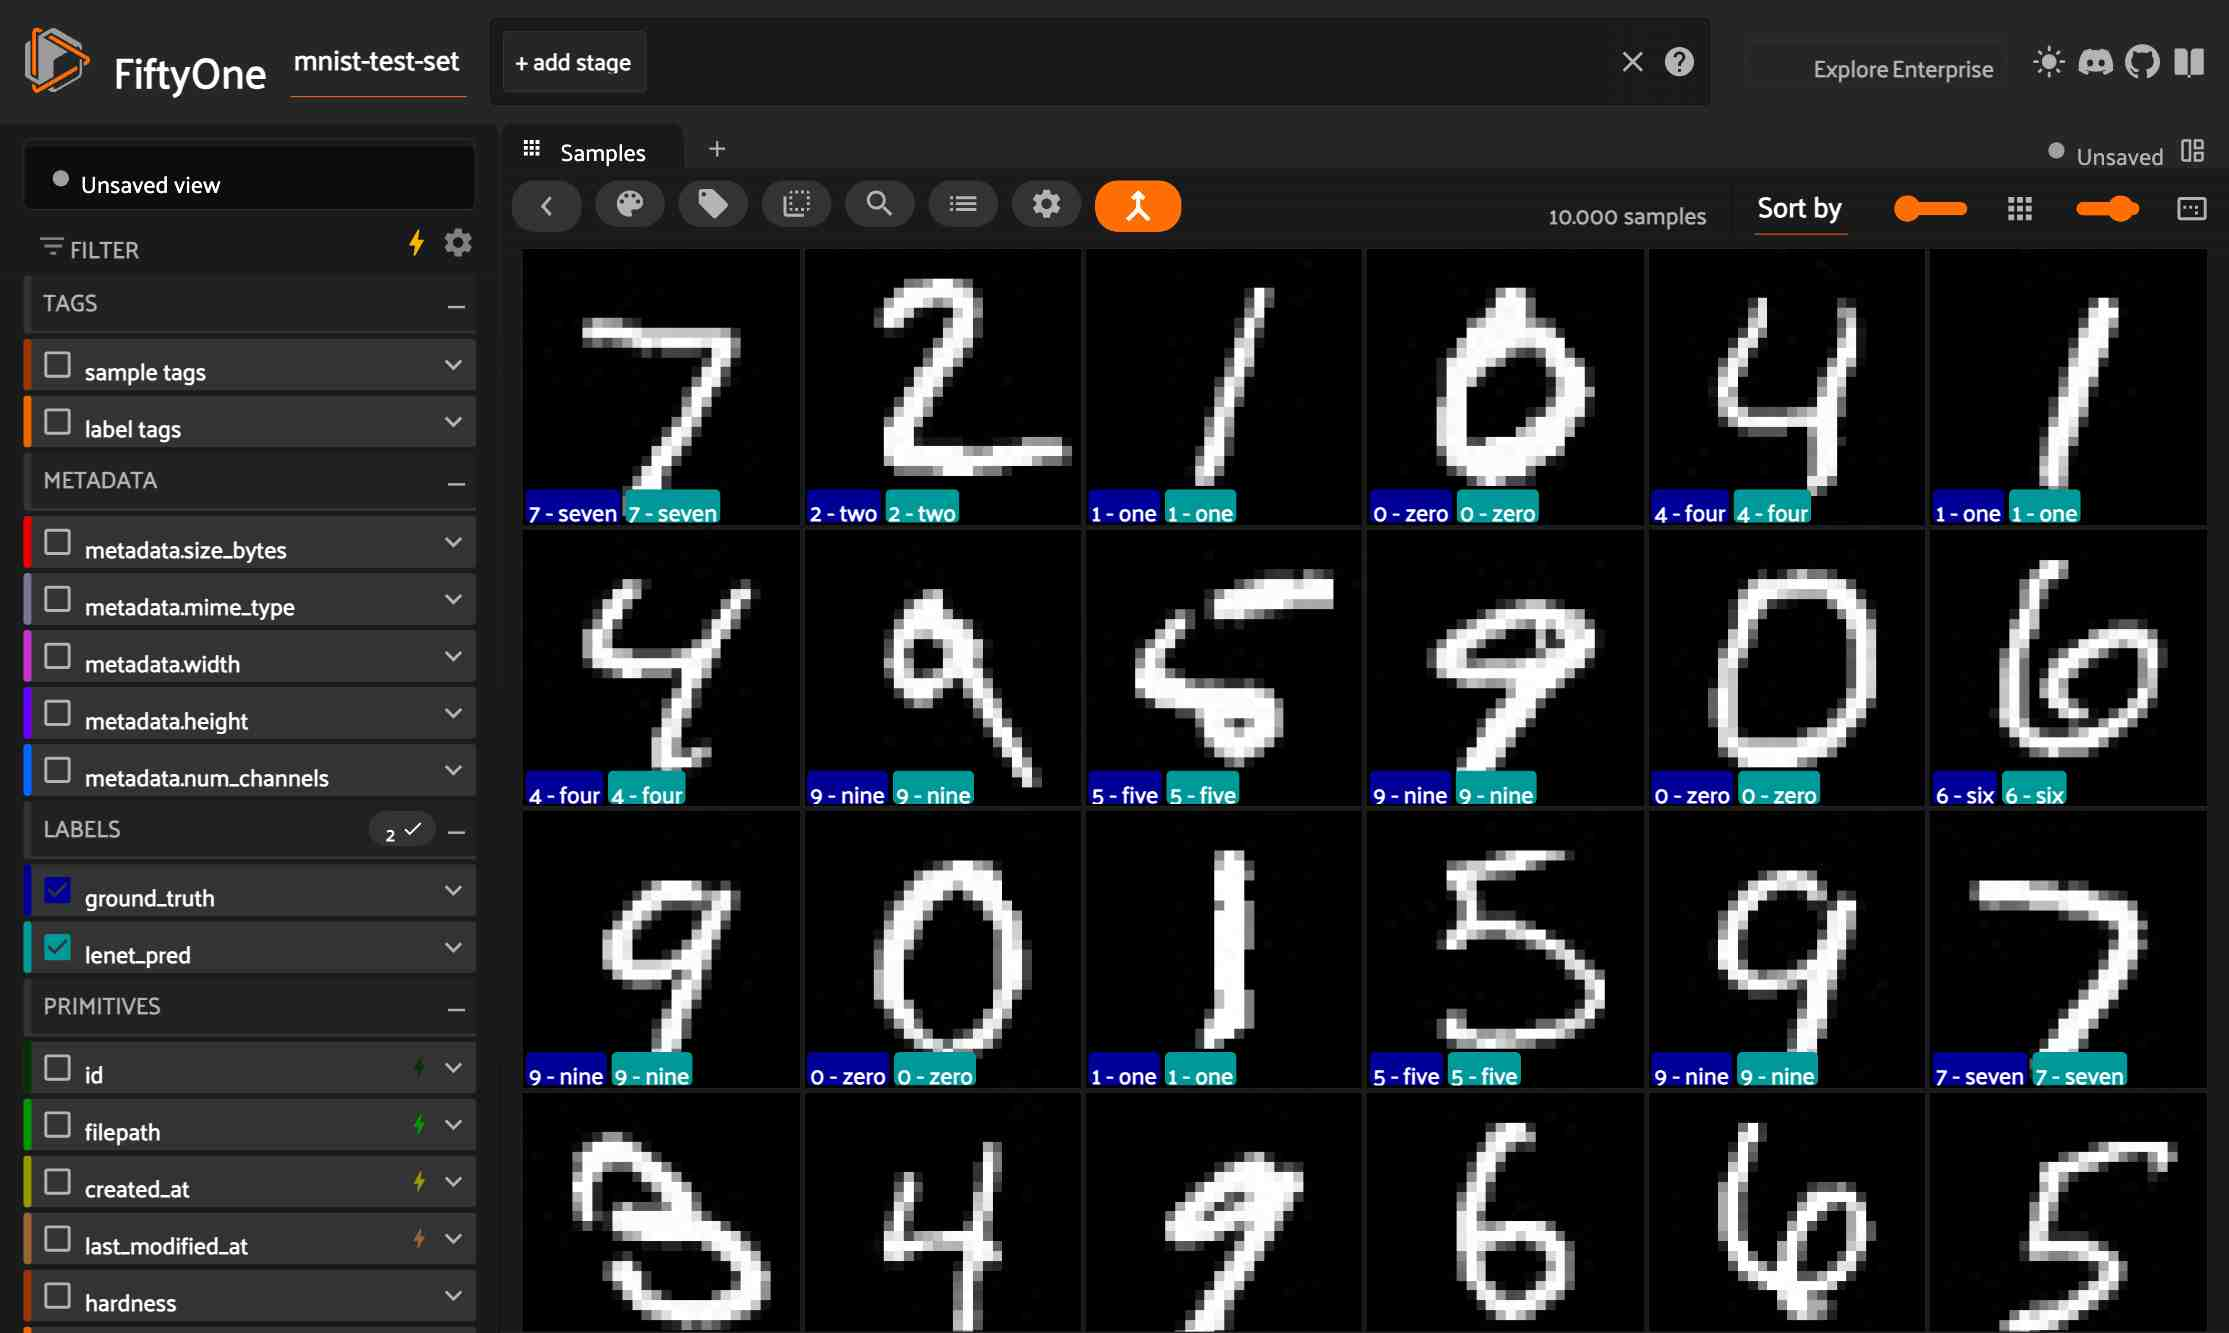


Open the App.
1. Click the 'Views' icon (bookmark symbol) to see 'test_low_conf' and 'test_suspicious'.
2. URL: http://localhost:5151/


In [13]:
# Compute Hardness & Mistakenness (Required before creating suspicious view)
evaluator.compute_brain_metrics(test_dataset, pred_field="lenet_pred")

# Create and SAVE the "Low Confidence" View
# This matches your request: confidence < 0.69
evaluator.create_low_confidence_view(
    test_dataset, 
    pred_field="lenet_pred", 
    threshold=0.69, 
    save_name="test_low_conf"
)

# Create and SAVE the "Suspicious" (High Mistakenness) View
# This matches your request: > 0.99 quantile
evaluator.create_suspicious_view(
    test_dataset, 
    q_percentile=0.99, 
    save_name="test_suspicious"
)

# Launch App
# Now "test_low_conf" and "test_suspicious" will appear in the Unsaved Views / Bookmarks section
session = fo.launch_app(test_dataset)

# Print the instructions for the user in case the app does not launch in the notebook cell
print(f"\nOpen the App.")
print(f"1. Click the 'Views' icon (bookmark symbol) to see 'test_low_conf' and 'test_suspicious'.")
print(f"2. URL: {session.url}")

### 🧐 Ex Post Test Set Analysis & Curation Strategy

Now that we have visualized the metrics on the Test set, we can confirm our hypotheses and formulate a plan to cure the Training set.

#### **1. Visual Evidence from Metrics**
*   **High Mistakenness (The "Suspicious" View):**
    *   **What we saw:** "Spaghetti Nines" (9s looking exactly like 4s) and ambiguous 5s vs 3s.
    *   **Insight:** These samples illustrate the **irreducible noise in the data**. They occupy similar positions in feature space but carry different ground-truth labels, which actively confuses the model’s decision boundaries during training.
*   **High Hardness (The "Low Confidence" View):**
    *   **What we saw:** Mostly egraded, broken strokes, or "scribbles" that barely resemble numbers.
    *   **Insight:** These samples represent the **lower quality boundary of the dataset**. The model is uncertain not because it is failing, but because the input itself is ambiguous or severely degraded.

#### **2. The Curation Plan (Training Set)**
Based on these findings, we will apply three specific strategies to the Training data:

1.  **The "Cleanup" (High Mistakenness):**
    *   **Action:** Identify and **remove** the top 1% of mistaken samples.
    *   **Why:** Contradictory labels corrupt the gradients. It is better to train on fewer clean samples than conflicting ones.

2.  **The "Augmentation" (Valid but Hard):**
    *   **Action:** Identify samples that are **correctly labeled but low confidence** (often rare handwriting styles like sharp 2s or crossed 7s). **Augment** them with rotations/shifts.
    *   **Why:** The model hasn't seen enough of these "tail" distributions. Augmentation forces it to learn these styles robustly.

3.  **The "Rejection" (The IDK Class):**
    *   **Action:** Identify samples that are effectively "garbage" (High Hardness + High Mistakenness). Relabel them to a new **11th Class: "IDK"**.
    *   **Why:** Instead of forcing the model to make a random guess on bad data, we explicitly train it to reject inputs it cannot recognize.

### Evaluator on Validation Set 

We repeat the evaluation using the `Evaluator` class, which was built specifically for FiftyOne, on the validation set. 

--- Inference on mnist-validation-set ---


Stored results in 'lenet_val_pred'.
--- Computing Brain Metrics for mnist-validation-set ---
Computing hardness...
 100% |███████████████| 9000/9000 [14.7s elapsed, 0s remaining, 634.0 samples/s]      
Hardness computation complete
Computing mistakenness...
 100% |███████████████| 9000/9000 [10.0s elapsed, 0s remaining, 920.4 samples/s]      
Mistakenness computation complete
Creating Low Confidence View (< 0.69)...
Saved view 'val_low_conf' with 102 samples.
Creating Suspicious View (Top 1.00% mistakenness)...
Saved view 'val_suspicious' with 90 samples.
--- Visualizing Confusion Matrix for mnist-validation-set ---


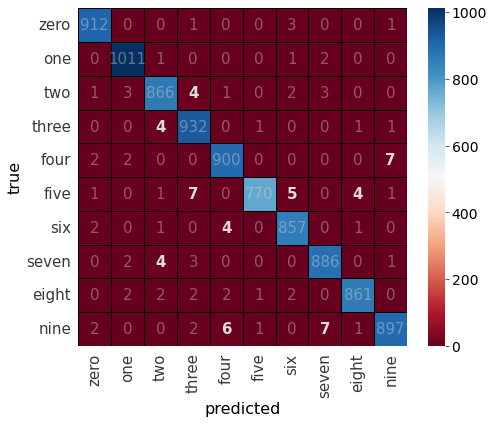


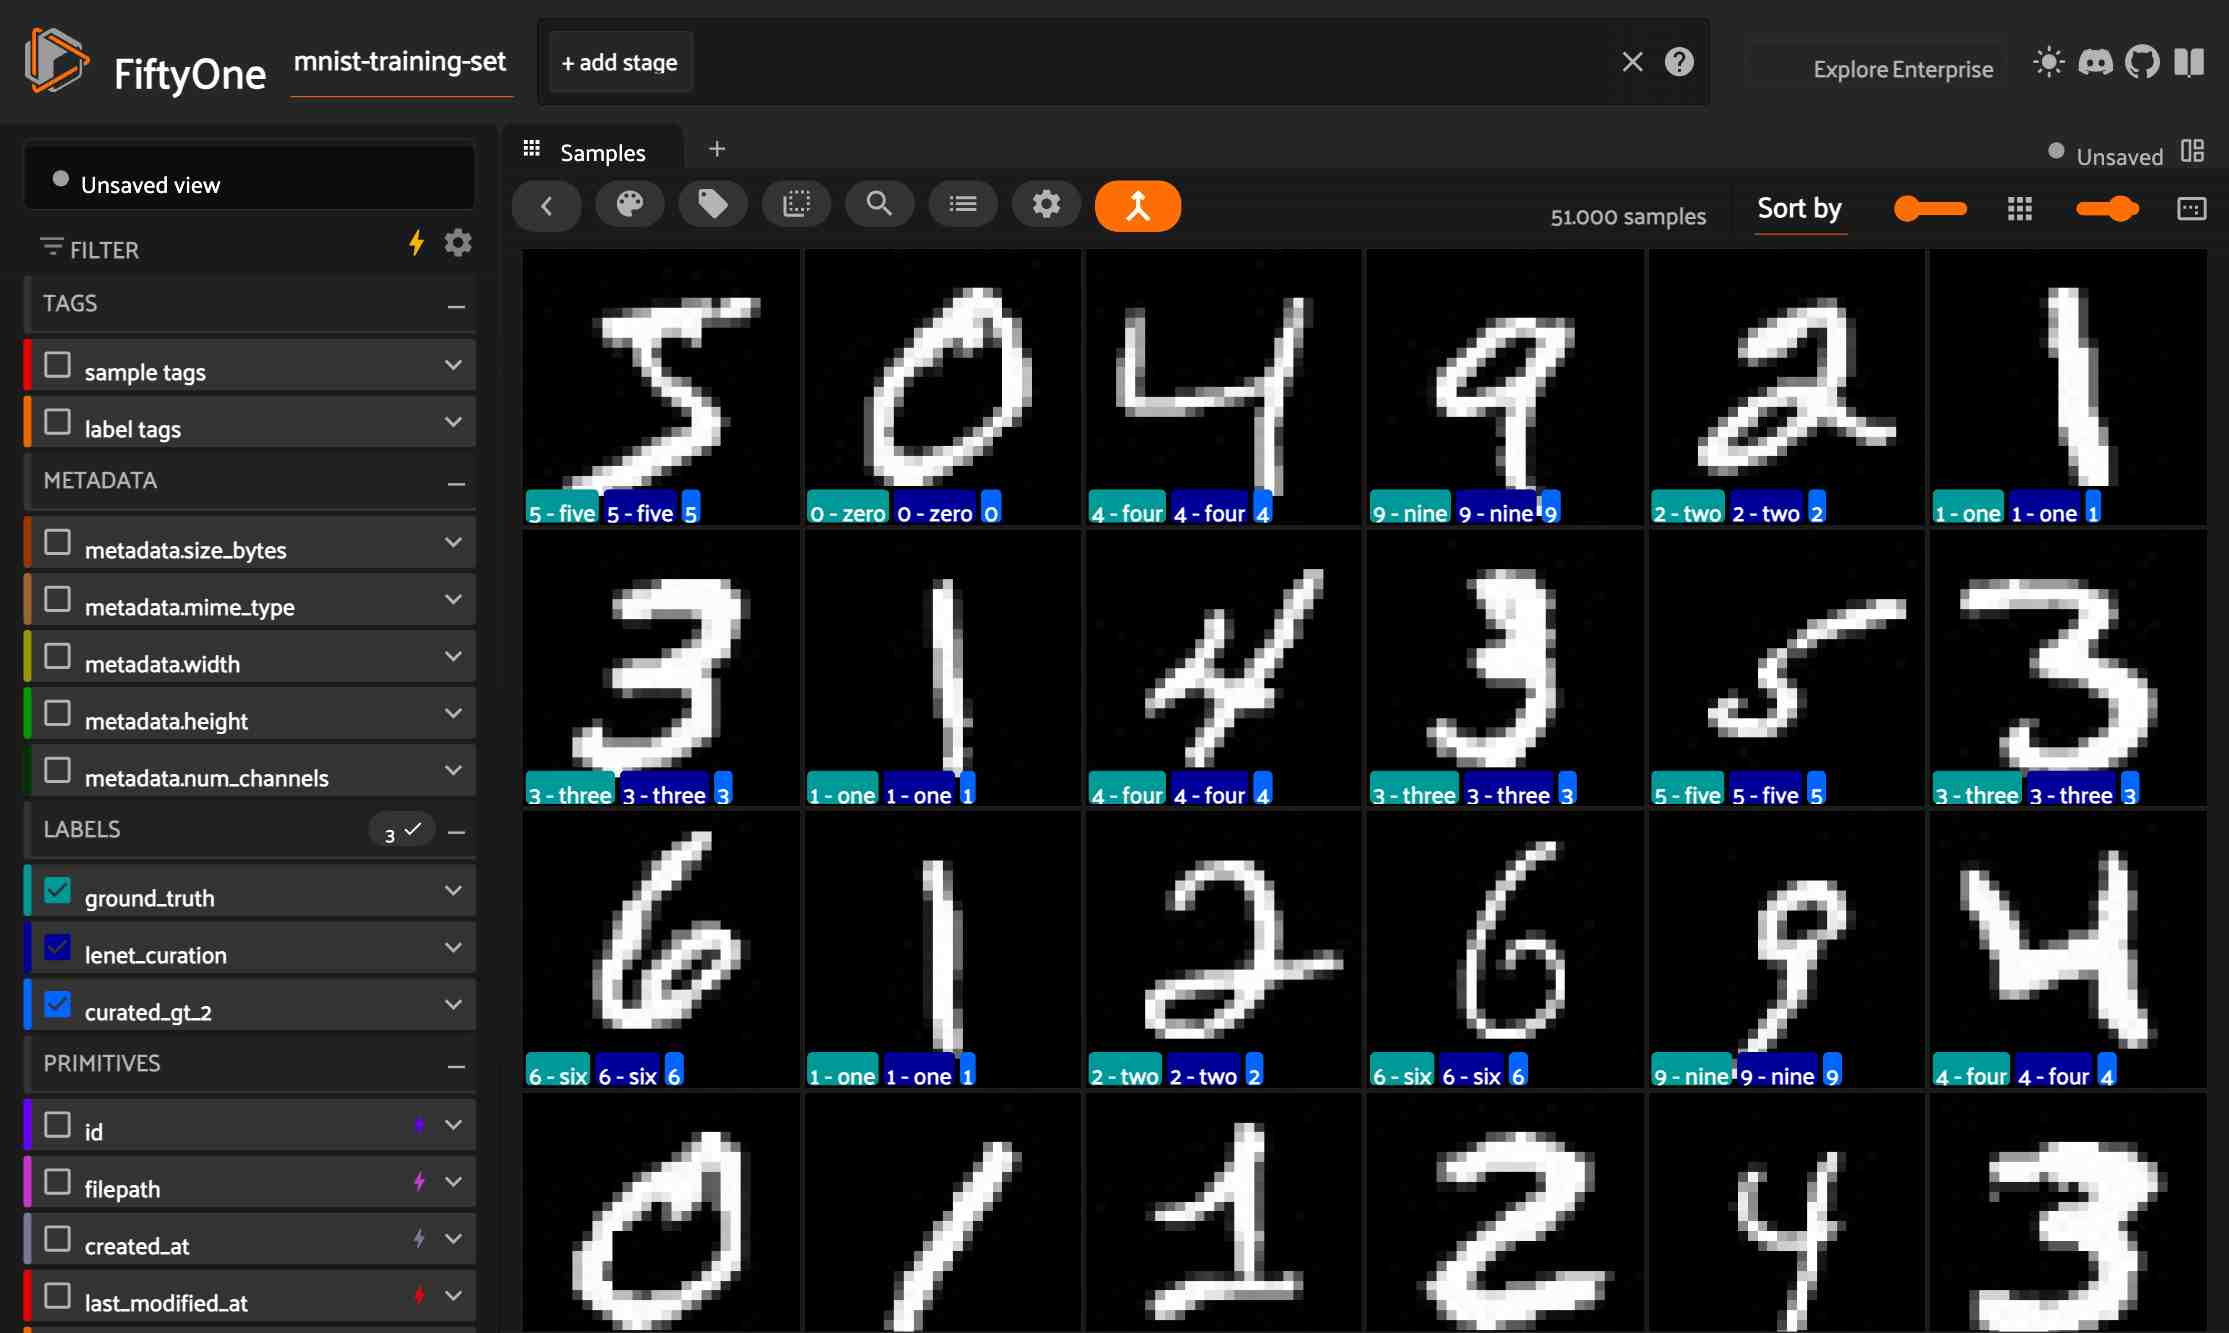

Validation analysis complete. Views 'val_low_conf' and 'val_suspicious' saved.

Open the App.
1. Click the 'Views' icon (bookmark symbol) to see 'test_low_conf' and 'test_suspicious'.
2. URL: http://localhost:5151/


In [14]:
# Run Inference on Validation Set
# We use the 'torch_val_set' defined in the data setup
evaluator.predict_and_store(val_dataset, torch_val_set, pred_field="lenet_val_pred")

# Compute Hardness & Mistakenness
evaluator.compute_brain_metrics(val_dataset, pred_field="lenet_val_pred")

# Create Views
# Low Confidence (< 0.69)
evaluator.create_low_confidence_view(
    val_dataset, 
    pred_field="lenet_val_pred", 
    threshold=0.69, 
    save_name="val_low_conf"
)

# Suspicious (Top 1% Mistakenness)
evaluator.create_suspicious_view(
    val_dataset, 
    q_percentile=0.99, 
    save_name="val_suspicious"
)

# Visualize Confusion Matrix
evaluator.visualize_confusion_matrix(val_dataset, pred_field="lenet_val_pred")

# Launch App
session = fo.launch_app(val_dataset)
print(f"Validation analysis complete. Views 'val_low_conf' and 'val_suspicious' saved.")

# Print the instructions for the user in case the app does not launch in the notebook cell
print(f"\nOpen the App.")
print(f"1. Click the 'Views' icon (bookmark symbol) to see 'test_low_conf' and 'test_suspicious'.")
print(f"2. URL: {session.url}")

### 🔍 Validation Set Analysis & Comparison

Comparing these results to our previous Test Set analysis:

1.  **Identical Error Patterns:**
    *   Examining the **Confusion Matrix** confirms that the dominant errors remain **9 vs 4 vs 7** (the "Spaghetti Nine" effect) and **5 vs 3**.
    *   This confirms that these are not random outliers in the Test set, but fundamental ambiguities present throughout the entire MNIST collection.

2.  **The "Garbage" Inputs:**
    *   The **Low Confidence View** (`val_low_conf`) captures the same type of "garbage" inputs we saw earlier: cut-off digits, shapeless blobs, and severe scribbles (e.g., the unreadable "8" in the second row).
    *   These samples reinforce our hypothesis that an **"IDK" (Rejection) Class** is necessary to handle inputs that simply do not look like numbers.

**Conclusion:** Since both the Test and Validation splits exhibit these specific pathologies, we can be certain that the **Training Set** contains thousands of these problematic samples. We can now proceed to curate the Training set with confidence, knowing that fixing these specific issues will directly address the model's primary failure modes.

## Workflow: drom Error Analysis to Embedding-Based Dataset Curation for LeNet-5

After analyzing **hard** and **suspicious** samples using prediction uncertainty (hardness) and potential annotation issues (mistakenness), we extend our analysis pipeline by examining the **intermediate represenations learned by our LeNet-5 model**. Before moving toward curating and retraining our model, we first explore how the network organizes the dataset in its learned feature space.

To do this, we extract the **84-dimensional embeddings** from the final fully connected layer of LeNet, store them in the FiftyOne dataset, and build a **similarity index** for fast nearest-neighbor search. These embeddings allow us to move beyond error-based analysis and quantify two key dataset-level properties:

- **Representativeness**: how well a sample reflects the central structure of its cluster  
- **Uniqueness**: how far a sample lies from all cluster centers, often indicating unusual or rare cases  

To visualize these high-dimensional features, we project them into 2D using:

- **PCA**: a linear dimensionality reduction method that preserves the directions of maximum variance, giving a global overview of the feature structure.
- **UMAP**: a nonlinear method that preserves local neighborhood relationships, often revealing clearer cluster separations than PCA.

Using these embeddings, we compute representativeness and uniqueness scores, generate quantile statistics, and create views of the **most representative** and **most unique** samples.  
We also visualize the embeddings in 2D to understand how the model organizes the digits and how cluster structure relates to prediction performance.

These steps give us a more holistic understanding of the dataset (complementing the earlier mistakenness and hardness analysis) and prepare us for **training set curation** in the next stage of the workflow.

As an optional extension, we propose an additional dataset curation strategy: 
**try constructing a training set composed only of the most representative and most unique samples** (as identified through embeddings), and retrain LeNet to explore how sample selection influences model performance.


In [15]:
# Extract Embeddings (FC1 Layer)
evaluator.extract_and_store_embeddings(train_dataset, torch_train_set, layer_name='fc1')

# Compute Similarity Index, Uniqueness, Representativeness
evaluator.compute_similarity_index(train_dataset)

# Compute 2D Projections (PCA/UMAP)
evaluator.compute_visualizations_2d(train_dataset)

# Compute Mistakenness/Hardness on Train (if not done already)
# We need this for the full analysis picture
if "mistakenness" not in train_dataset.get_field_schema():
    # Ensure predictions exist first
    evaluator.predict_and_store(train_dataset, torch_train_set, pred_field="lenet_curation")
    evaluator.compute_brain_metrics(train_dataset, pred_field="lenet_curation")

# Identify Extreme Samples
# Most Unique (Outliers/Edge Cases)
most_unique_view = evaluator.get_extreme_samples(train_dataset, "uniqueness", 0.999)
train_dataset.save_view("most_unique", most_unique_view)

# Most Representative (Prototypes)
most_rep_view = evaluator.get_extreme_samples(train_dataset, "representativeness", 0.999)
train_dataset.save_view("most_representative", most_rep_view)

print(f"Views saved: 'most_unique' ({len(most_unique_view)}) and 'most_representative' ({len(most_rep_view)})")

# Optional: Strategy - Create Datasets for Retraining
# We can prepare these PyTorch datasets now for the later section
print("\nCreating PyTorch Datasets for Alternative Strategy...")

unique_ds = CustomTorchImageDataset(
    most_unique_view, 
    label_map=label_map, 
    image_transforms=image_transforms
)

rep_ds = ConcatDataset([
    CustomTorchImageDataset(most_rep_view, label_map=label_map, image_transforms=image_transforms),
    unique_ds # Combining both as per strategy
])

print(f"Created 'unique_ds' ({len(unique_ds)} samples) and combined 'rep_ds' ({len(rep_ds)} samples).")

# 7. Launch App to visualize the Embeddings
session = fo.launch_app(train_dataset)

--- Extracting Embeddings from 'fc1' on mnist-training-set ---


Extracting: 100%|██████████| 797/797 [00:09<00:00, 83.63it/s]


Embedding Shape: (51000, 84)
Embeddings stored in 'lenet_embeddings'.
--- Computing Similarity Index & Metrics on mnist-training-set ---
Computing uniqueness...
Uniqueness computation complete
Computing representativeness...
Computing clusters for 51000 embeddings; this may take awhile...
Representativeness computation complete
Similarity, Uniqueness, and Representativeness computed.
--- Computing 2D Visualizations (PCA/UMAP) on mnist-training-set ---
Generating visualization...
Generating visualization...
UMAP( verbose=True)
Sat Nov 22 02:29:44 2025 Construct fuzzy simplicial set
Sat Nov 22 02:29:44 2025 Finding Nearest Neighbors
Sat Nov 22 02:29:44 2025 Building RP forest with 16 trees
Sat Nov 22 02:29:50 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Nov 22 02:30:02 2025 Finished Nearest Neighbor Search
Sat Nov 22 02:30:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Nov 22 02:30:13 2025 Finished embedding
PCA and UMAP computed.
--- Inference on mnist-training-set ---


Stored results in 'lenet_curation'.
--- Computing Brain Metrics for mnist-training-set ---
Computing hardness...
 100% |█████████████| 51000/51000 [1.4m elapsed, 0s remaining, 619.4 samples/s]      
Hardness computation complete
Computing mistakenness...
 100% |█████████████| 51000/51000 [59.3s elapsed, 0s remaining, 864.7 samples/s]      
Mistakenness computation complete
Finding top 0.1% uniqueness (Thresh: 0.7878)
Finding top 0.1% representativeness (Thresh: 0.9025)
Views saved: 'most_unique' (51) and 'most_representative' (51)

Creating PyTorch Datasets for Alternative Strategy...
Created 'unique_ds' (51 samples) and combined 'rep_ds' (102 samples).


### 🍝 PCA vs. UMAP: Dataset Insights beyond the "Spaghetti Nine"

By extracting the 84-dimensional feature vectors from LeNet's penultimate layer provides insight into how the model maps the dataset to the latent space. The correct visualisations can be achieved by clicking on the 'Embeddings' panel on the right, selecting the 'pca_lenet' or 'umap_lenet' view, and then colouring the two different 2D projections by ground truth labels.

#### **1. PCA vs. UMAP** 
*   **PCA (Linear Projection):**
    *   **Observation:** The PCA plot forms a "starburst" pattern. While distinct arms appear for different digits, there is significant overlap in the center.
    *   **Takeaway:** PCA preserves global variance but fails to separate complex, non-linear boundaries. It suggests that the classes are separable, but not linearly. Hovering over the overlapping clusters makes it possible to identify **handwritten edge cases**, such as 4s and 8s that can be easily mistaken for 9s, even if these samples do not have particularly low uniqueness scores.
*   **UMAP (Manifold Learning):**
    *   **Observation:** UMAP reveals stunningly clear, separated "islands" for each digit class.
    *   **Takeaway:** This confirms that **LeNet has learned strong discriminative features**. Thee “bridges” or points between clusters highlight the **most ambiguous samples**, for example, 3s resembling 5s, which often reveal **annotation errors**, artifacts, or inherently confusing digits.

Additionally, UMAP clusters are more suitable for identifying **outliers and edge cases** relative to their cluster centers. These samples tend to have **higher uniqueness scores** than points in overlapping PCA clusters, often representing **low-quality images** (e.g. scribbles, misannotations, or otherwise problematic samples) that could be removed in a dataset curation.

#### **2. Representativeness vs. Uniqueness**
FiftyOne's similarity analysis gives us two sorting mechanisms:

*   **Most Representative (or ideal digits):**
    *   **Observation:** Samples in which the stroke patterns clearly identify a specific digit. 
    *   **Takeaway:** These samples lie at the dense center of their respective UMAP clusters. While safe, training only on these would make the model susceptible and less robust to data noise.
*   **Most Unique (or edge cases and ambiguities):**
    *   **Observation:** Extreme slants, cut-off strokes, strange loops and heavy artefacts. Some look like completely different symbols and have been mislabelled by the annotators, while others still retain distinctive features of the original digits, which may help the model generalize better (e.g., points at the tip of the UMAP “leaf” cluster of 5s).
    *   **Takeaway:** These samples sit at the far edges of the embedding space, distant from any cluster center. The *actionable strategy* that would then follow would then to devide them by,
        *   **Valid Unique Samples (e.g., a sharp-cornered '2'):**  These are samples to **augment**, to teach the model that these variations are valid. These were the samples that were previously producing **low Mistakeness**, but **moderate/high Hardness**.
        *   **Invalid Unique Samples (e.g., a cut-off blob):** These are samples that should either be relabelled as `"IDK class"` or removed from the training set. These were the samples that were mostly producing **high Hardness** and **high Mistakeness**.

# Part 2: Supervised Fine-Tuning with LeNet-5 and Dataset Curation with FiftyOne

In the second part of the notebook, after analyzing **dataset and model limitations** via FiftyOne’s **hardness**, **mistakenness**, **uniqueness**, and **representativeness** (the latter two in the embedding space), we now **curate the dataset** in a semi-manual, active learning workflow.  

Given that uniqueness resulted be more actionable when combined with the augmentation in the previous section (strategies already explored in the tutorial) and encompasses edge cases of both mistakenness and hardness, we will focus primarily on mistakenness and hardness. Using mistakenness and hardness, samples in the **2%, 10%, and 20% quantiles** are assigned an `"IDK"` label. We train and benchmark three models:

- **Multiclass classifier** with 11 classes (10 digits + `"IDK"`)  
- **Multilabel classifier** choosing between digit and `"IDK"`  
- **Binary classifier** distinguishing **known digits** vs `"IDK"`  

Finally, we compare the **baseline model** on the new curated test set to identify where it was likely guessing on ambiguous or low-quality samples.

This second part will cover:

- Building new curation targets using FiftyOne Field Views and Brain Metrics  
- Defining a `CurationStrategy` class to convert FiftyOne objects into trainable PyTorch tensors and prepare data for the three different models  
- Implementing a dynamic focal loss function to address class imbalance from the relatively small number of `"IDK"` labels  
- Using FiftyOne `Classification` objects to evaluate the new models and store predictions  
- Benchmarking against the baseline using F1-macro and per-class F1-macro scores

## Creation of Curated Datasets with the `"IDK"` Label

Since the top 1–2% of mistaken or highly confused samples typically correspond to the most degraded, ambiguous, or “spaghetti-like” digits, labeling only these as `"IDK"` would result in a **severely imbalanced dataset**. This extreme imbalance could lead the model to interpret the `"IDK"` class as pure aleatoric noise rather than a meaningful alternative class. To avoid this, we create **three curated versions** of the dataset using the top 20%, 10%, and 2% quantiles of the joint (hardness, mistakenness) distribution. Each curated dataset is then inspected via FiftyOne, by creating Saved Views for the "IDK" samples at each level. Since the levels are cumulative (Level 20 contains everything in Level 2, plus more), the most interesting thing to visualize is the "Drift".


In [16]:
def setup_multilevel_curation(fo_dataset):
    print(f"--- Setting up Multi-Level Curation for {fo_dataset.name} ---")
    
    # Ensure Metrics Exist
    if "hardness" not in fo_dataset.get_field_schema():
        print("   Computing Brain metrics...")
        preds = [f for f in fo_dataset.get_field_schema() if "pred" in f or "curation" in f]
        if not preds: 
            print("    No prediction field found. Cannot compute IDK candidates.")
            return {}
        # Compute using the first found prediction field
        fob.compute_hardness(fo_dataset, label_field=preds[0])
        fob.compute_mistakenness(fo_dataset, pred_field=preds[0], label_field="ground_truth")

    # Define the levels (Name -> Quantile)
    # Top 2% = 0.98 quantile
    # Top 10% = 0.90 quantile
    # Top 20% = 0.80 quantile
    curation_levels = {
        "2": 0.98,
        "10": 0.90,
        "20": 0.80
    }
    
    # Dictionary to store ID sets: {'2': set(...), '10': set(...), '20': set(...)}
    idk_sets = {}

    # Loop through levels and create fields
    for level_name, quantile in curation_levels.items():
        # Compute Thresholds for this level
        h_thresh = fo_dataset.quantiles("hardness", [quantile])[0]
        m_thresh = fo_dataset.quantiles("mistakenness", [quantile])[0]
        
        # Identify IDK IDs (Union logic)
        # Logic: Is it in the top X% of Hardness OR top X% of Mistakenness?
        idk_view = fo_dataset.match(
            (VF("hardness") > h_thresh) | 
            (VF("mistakenness") > m_thresh)
        )
        current_ids = set(idk_view.values("id"))
        idk_sets[level_name] = current_ids
        
        print(f"   [Level {level_name}%] Thresholds: H>{h_thresh:.2f}|M>{m_thresh:.2f} -> Found {len(current_ids)} IDK samples")

        # Create specific Ground Truth Field (e.g., 'curated_gt_20')
        gt_field_name = f"curated_gt_{level_name}"
        new_labels = []
        
        # We iterate the dataset to build labels based on the current ID set
        for s in fo_dataset:
            if s.id in current_ids:
                # IDK Sample
                new_labels.append(fo.Classification(label="10"))
            else:
                # Regular Digit (clean label)
                clean_lbl = str(s.ground_truth.label).split("-")[0].strip()
                new_labels.append(fo.Classification(label=clean_lbl))
        
        fo_dataset.set_values(gt_field_name, new_labels)
    
    print(f"    Created fields: curated_gt_2, curated_gt_10, curated_gt_20\n")
    return idk_sets

# --- Apply to all splits ---
# These now return dictionaries, e.g., idk_train['20'] gives the IDs for the 20% split
idk_train = setup_multilevel_curation(train_dataset)
idk_val = setup_multilevel_curation(val_dataset)
idk_test = setup_multilevel_curation(test_dataset)

--- Setting up Multi-Level Curation for mnist-training-set ---
   [Level 2%] Thresholds: H>0.49|M>0.08 -> Found 1137 IDK samples
   [Level 10%] Thresholds: H>0.01|M>0.00 -> Found 5140 IDK samples
   [Level 20%] Thresholds: H>0.00|M>0.00 -> Found 10232 IDK samples
    Created fields: curated_gt_2, curated_gt_10, curated_gt_20

--- Setting up Multi-Level Curation for mnist-validation-set ---
   [Level 2%] Thresholds: H>0.54|M>0.12 -> Found 225 IDK samples
   [Level 10%] Thresholds: H>0.01|M>0.00 -> Found 910 IDK samples
   [Level 20%] Thresholds: H>0.00|M>0.00 -> Found 1807 IDK samples
    Created fields: curated_gt_2, curated_gt_10, curated_gt_20

--- Setting up Multi-Level Curation for mnist-test-set ---
   [Level 2%] Thresholds: H>0.53|M>0.12 -> Found 242 IDK samples
   [Level 10%] Thresholds: H>0.01|M>0.00 -> Found 1011 IDK samples
   [Level 20%] Thresholds: H>0.00|M>0.00 -> Found 2005 IDK samples
    Created fields: curated_gt_2, curated_gt_10, curated_gt_20



--- Creating Inspection Views for mnist-training-set ---
   Saved view 'IDK_Level_2_percent': 1137 samples
   Saved view 'IDK_Level_10_percent': 5140 samples
   Saved view 'IDK_Level_20_percent': 10232 samples
   Saved view 'Diff_Level_2_vs_20': 9095 samples (The 'Gray Area')

 Launching App for Inspection...



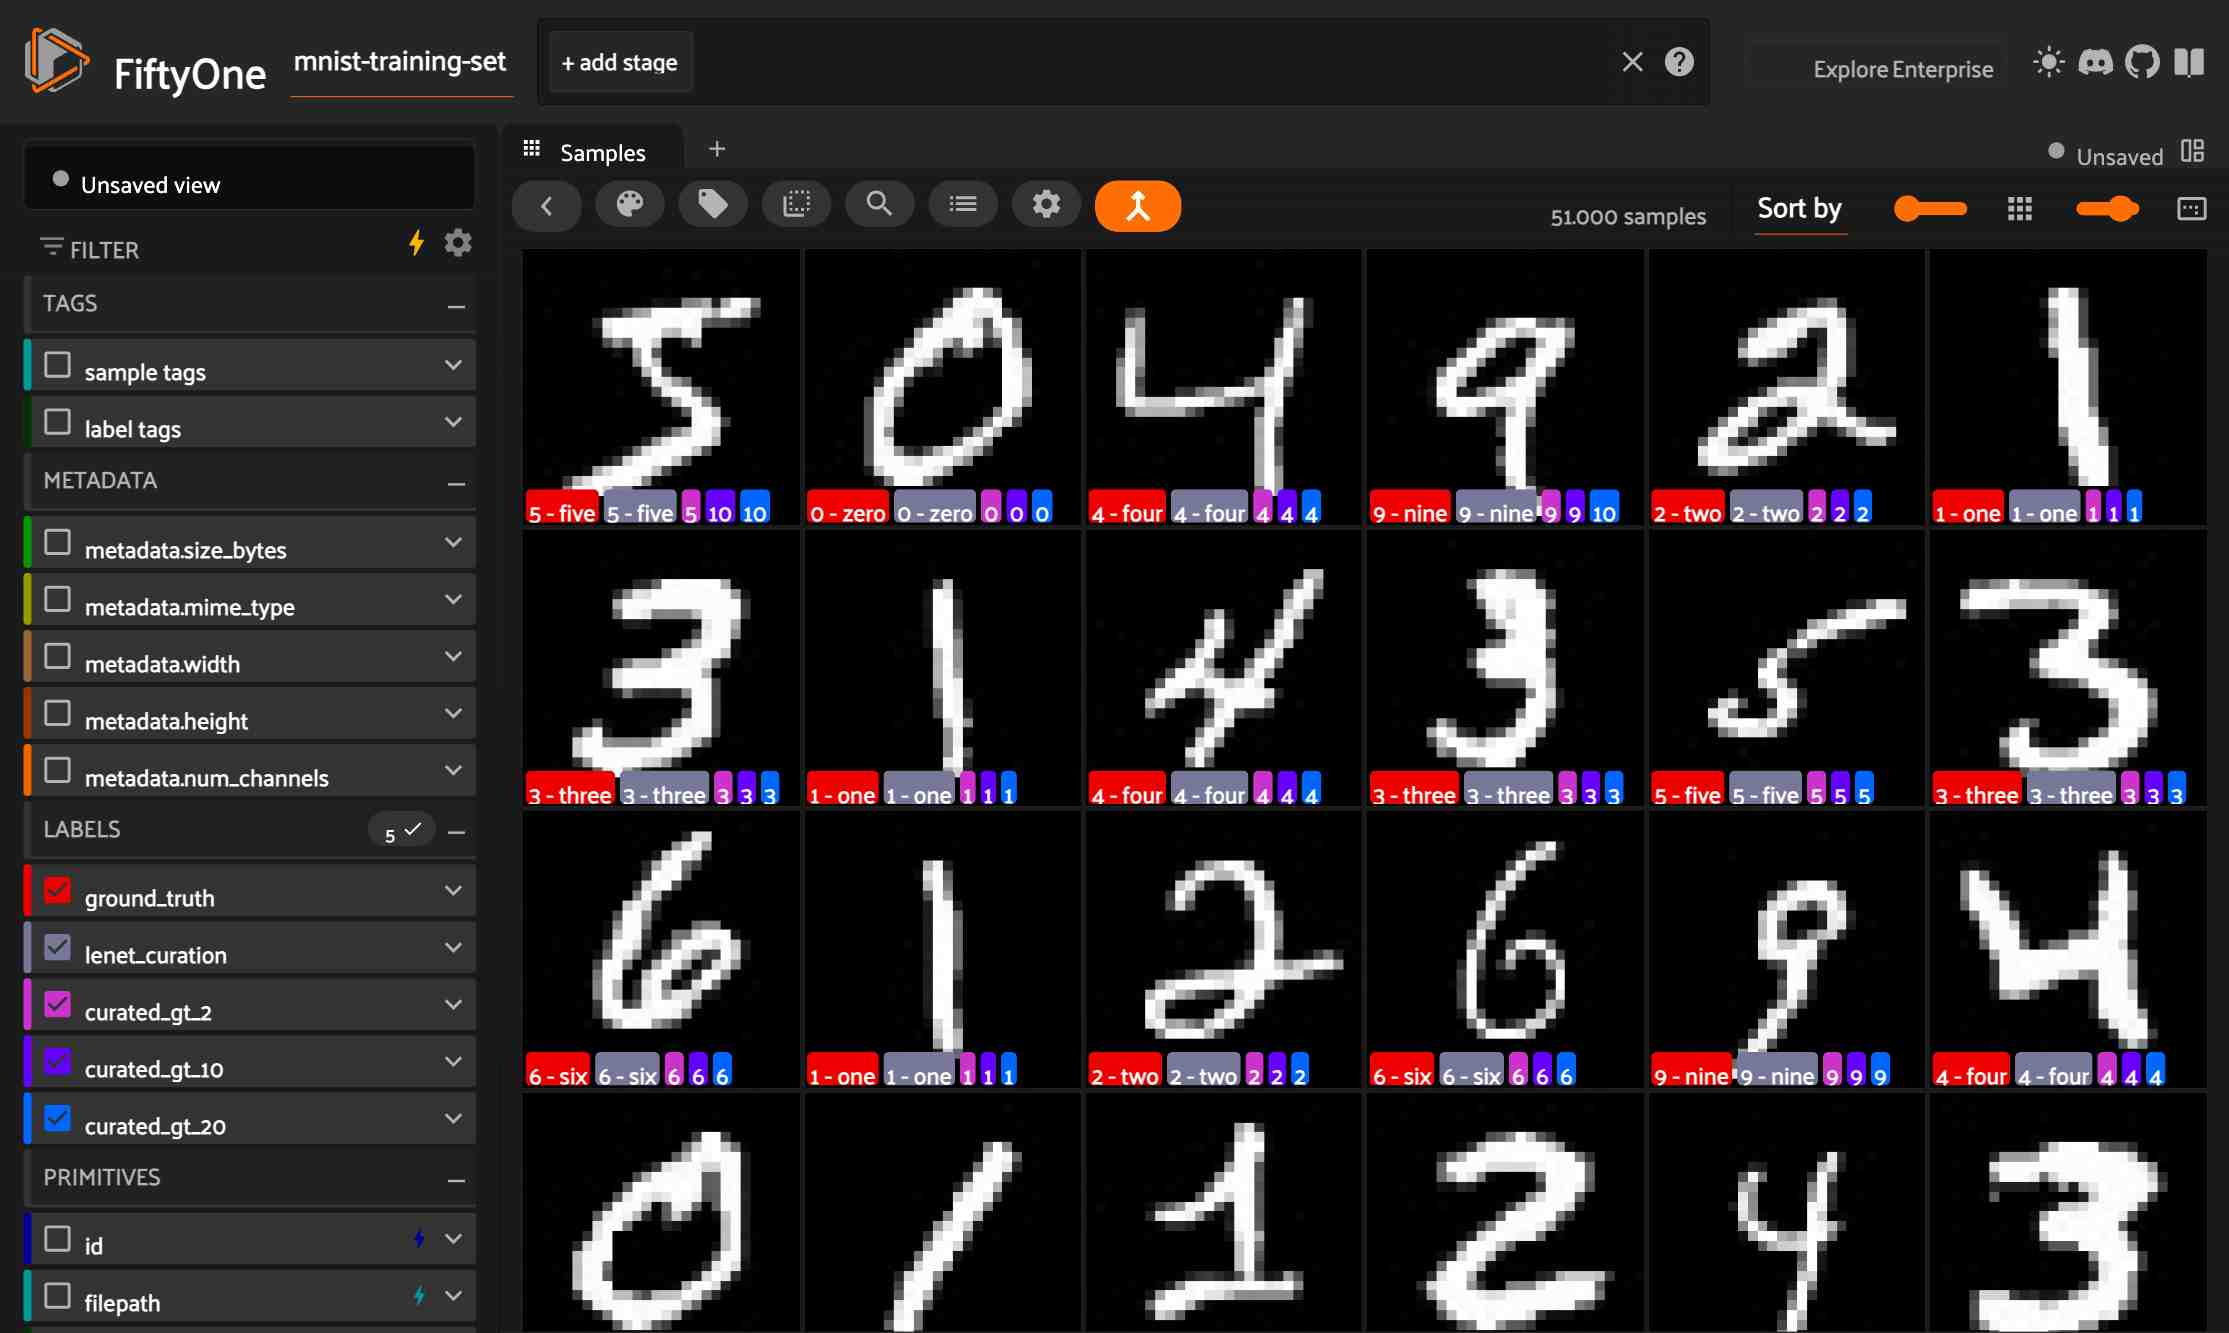


[Level 2%] Total IDK: 1137
   - Only Hard (Unclear features/blurred/confused Digits): 117
   - Only Mistaken (Confident Label Errors): 117
   - Both (Total Garbage): 903
   - Thresholds used: H>0.486, M>0.083

[Level 10%] Total IDK: 5140
   - Only Hard (Unclear features/blurred/confused Digits): 40
   - Only Mistaken (Confident Label Errors): 40
   - Both (Total Garbage): 5060
   - Thresholds used: H>0.010, M>0.001

[Level 20%] Total IDK: 10232
   - Only Hard (Unclear features/blurred/confused Digits): 35
   - Only Mistaken (Confident Label Errors): 32
   - Both (Total Garbage): 10165
   - Thresholds used: H>0.000, M>0.000

 INSPECTION GUIDE:
1. Open the 'Views' dropdown (Bookmark icon).
2. Select 'IDK_Level_2_percent' -> Higher number of highly mistaken and uncertain samples.
3. Select 'Diff_Level_2_vs_20' -> Samples still share visual features with other digits, despite their low hardness and inaccuracy.
4. In the Sidebar (left), check/uncheck 'curated_gt_2', 'curated_gt_10', etc. t

In [17]:
def create_curation_inspection_views(fo_dataset):
    print(f"--- Creating Inspection Views for {fo_dataset.name} ---")
    
    levels = ["2", "10", "20"]
    
    # 1. Create standard views for each level (Show me the IDK samples)
    for level in levels:
        view_name = f"IDK_Level_{level}_percent"
        gt_field = f"curated_gt_{level}"
        
        # Filter: Where the label is "10" (IDK)
        view = fo_dataset.match(VF(f"{gt_field}.label") == "10")
        
        # Save View
        if fo_dataset.has_saved_view(view_name):
            fo_dataset.delete_saved_view(view_name)
            
        fo_dataset.save_view(view_name, view)
        print(f"   Saved view '{view_name}': {len(view)} samples")

    # 2. Create a "Marginal" View (The Difference)
    # Show me samples that are IDK in Level 20, but were considered VALID in Level 2.
    margin_view_name = "Diff_Level_2_vs_20"
    margin_view = fo_dataset.match(
        (VF("curated_gt_20.label") == "10") &  
        (VF("curated_gt_2.label") != "10")     
    )
    
    if fo_dataset.has_saved_view(margin_view_name):
        fo_dataset.delete_saved_view(margin_view_name)
    
    fo_dataset.save_view(margin_view_name, margin_view)
    print(f"   Saved view '{margin_view_name}': {len(margin_view)} samples (The 'Gray Area')")

# Apply to Train dataset (richest source of data)
create_curation_inspection_views(train_dataset)

# Launch App
print("\n Launching App for Inspection...")
session = fo.launch_app(train_dataset)

def analyze_curation_levels(fo_dataset):    
    levels = ["2", "10", "20"]
    
    for level in levels:
        field = f"curated_gt_{level}"
        
        # Total IDK Samples
        idk_view = fo_dataset.match(VF(f"{field}.label") == "10")
        count = len(idk_view)
        
        # Breakdown: How many are IDK because of Hardness vs Mistakenness?
        # We re-calculate the thresholds used for this level to verify
        # (Top X% quantile)
        q = float(level)
        q_val = 1.0 - (q / 100.0) # e.g. 2% -> 0.98
        
        h_thresh = fo_dataset.quantiles("hardness", [q_val])[0]
        m_thresh = fo_dataset.quantiles("mistakenness", [q_val])[0]
        
        # Count Hard vs Mistaken
        num_hard = len(idk_view.match(VF("hardness") > h_thresh))
        num_mistaken = len(idk_view.match(VF("mistakenness") > m_thresh))
        
        # Count intersections (High Hardness AND High Mistakenness)
        num_both = len(idk_view.match((VF("hardness") > h_thresh) & (VF("mistakenness") > m_thresh)))
        
        print(f"\n[Level {level}%] Total IDK: {count}")
        print(f"   - Only Hard (Unclear features/blurred/confused Digits): {num_hard - num_both}")
        print(f"   - Only Mistaken (Confident Label Errors): {num_mistaken - num_both}")
        print(f"   - Both (Total Garbage): {num_both}")
        print(f"   - Thresholds used: H>{h_thresh:.3f}, M>{m_thresh:.3f}")

analyze_curation_levels(train_dataset)

print("\n INSPECTION GUIDE:")
print("1. Open the 'Views' dropdown (Bookmark icon).")
print("2. Select 'IDK_Level_2_percent' -> Higher number of highly mistaken and uncertain samples.")
print("3. Select 'Diff_Level_2_vs_20' -> Samples still share visual features with other digits, despite their low hardness and inaccuracy.")
print("4. In the Sidebar (left), check/uncheck 'curated_gt_2', 'curated_gt_10', etc. to see labels change on the images.")

---

💡 **Note:** In the top 10% and 20% quantile, both hardness and mistakenness values often remain close to 0. This means the model is very (over)confident on these samples, reinforcing the signs of overfitting observed in the training patterns.


In the next cell, we introduce the CurationStrategyDataset, a lightweight wrapper that dynamically assigns `"IDK"` labels without duplicating image data. It is memory-efficient and uses lazy loading, but the original weighted-sampler caused heavy disk I/O by triggering 50k image reads. We fix this by computing sampling weights entirely from metadata in RAM, removing the bottleneck.

Applying [(Araslanov and Roth, 2021)](https://openaccess.thecvf.com/content/CVPR2021/papers/Araslanov_Self-Supervised_Augmentation_Consistency_for_Adapting_Semantic_Segmentation_CVPR_2021_paper.pdf) to our classification setting,we design a weighted sampler that increases the sampling probability of rare or underrepresented labels, improving class balance during training.

In [18]:
class CurationStrategyDataset(Dataset):
    def __init__(self, fo_dataset, idk_ids, mode="multiclass", transforms=None):
        self.paths = fo_dataset.values("filepath")
        self.raw_labels = fo_dataset.values("ground_truth.label")
        self.ids = fo_dataset.values("id")
        self.idk_ids = idk_ids
        self.transforms = transforms
        self.mode = mode
        # Map '0'-'9' strings to integers
        self.label_map = {str(i): i for i in range(10)}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('L')
        if self.transforms:
            img = self.transforms(img)
            
        sid = self.ids[idx]
        raw_lbl = self.raw_labels[idx]
        
        # Parse e.g. "0 - zero" to "0"
        label_str = raw_lbl.split("-")[0].strip()
        digit_idx = self.label_map[label_str]
        
        is_idk = sid in self.idk_ids
        
        if self.mode == "multiclass":
            # 10 = IDK
            target = 10 if is_idk else digit_idx
            return img, torch.tensor(target, dtype=torch.long)
            
        elif self.mode == "multilabel":
            # [0..9, IDK]
            target = torch.zeros(11, dtype=torch.float32)
            target[digit_idx] = 1.0
            if is_idk:
                target[10] = 1.0
            return img, target
            
        elif self.mode == "binary":
            # 1 = IDK, 0 = Known
            target = 1 if is_idk else 0
            return img, torch.tensor(target, dtype=torch.long)

def get_weighted_sampler_optimized(dataset):
    """
    Calculates weights purely from metadata (RAM), skipping image loading.
    1000x faster than the previous version.
    """
    from torch.utils.data import WeightedRandomSampler
    
    print("Computing weights for sampler (Optimized)...")
    targets = []
    
    # Access internal metadata directly to avoid __getitem__ (which loads images)
    # We replicate the logic of __getitem__ but only for the label
    for idx in range(len(dataset)):
        sid = dataset.ids[idx]
        raw_lbl = dataset.raw_labels[idx]
        
        # Parse Label
        label_str = raw_lbl.split("-")[0].strip()
        digit_idx = dataset.label_map[label_str]
        
        # Check IDK status
        is_idk = sid in dataset.idk_ids
        
        # Determine target based on mode
        if dataset.mode == "multiclass":
            t = 10 if is_idk else digit_idx
        elif dataset.mode == "multilabel":
            # For sampling, we group all IDK together and all Digits together
            # This is a heuristic: use the primary class index
            t = 10 if is_idk else digit_idx
        elif dataset.mode == "binary":
            t = 1 if is_idk else 0
            
        targets.append(t)

    # Weighting Logic
    targets_tensor = torch.tensor(targets)
    class_sample_count = torch.bincount(targets_tensor)
    weight = 1. / class_sample_count.float() # probability for a training image to be drawn
    samples_weight = weight[targets_tensor]
    
    return WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

## Training Scheme for 3 Classifier for the `"IDK"` Label

We now define and test the three strategies introduced earlier: a variation of LeNet-5 trained as an **11-class multiclass classifier**; a **multilabel classifier**; and a **binary classifier**.  Because training on an `"IDK"` class introduces **severe class imbalance** (even at the 20% quantile, the `"IDK"` subset rarely exceeds ~10k samples), we adopt a **dynamic Focal Loss** formulation [(Araslanov and Roth, 2021)](https://openaccess.thecvf.com/content/CVPR2021/papers/Araslanov_Self-Supervised_Augmentation_Consistency_for_Adapting_Semantic_Segmentation_CVPR_2021_paper.pdf), a weighted extension of Cross-Entropy.

In this version of Focal Loss, an exponential moving average of class priors is updated at every training step, and the focusing parameter γ (gamma) controls how strongly the loss down-weights easy or over-represented samples. This helps stabilize training, particularly for the binary model where the "I-Know" class would otherwise dominate the learning dynamics.

In [19]:
class DynamicFocalLoss(nn.Module):
    """
    Implements Part B: Weighted Focal Loss with EMA-updated priors.
    Adapts pixel-level logic to image-level classification.
    """
    def __init__(self, num_classes, mode="multiclass", gamma=2.0, ema_alpha=0.9, device='cuda'):
        super(DynamicFocalLoss, self).__init__()
        self.num_classes = num_classes
        self.mode = mode
        self.gamma = gamma
        self.ema_alpha = ema_alpha # The 'gamma' from your equation (3)
        self.device = device
        
        # Initialize priors uniformly (1/C)
        # We register as buffer so it saves with state_dict but isn't a parameter
        self.register_buffer('class_priors', torch.ones(num_classes) / num_classes)

    def update_priors(self, targets):
        """Equation (3): Xt+1 = γXt + (1-γ)X"""
        with torch.no_grad():
            current_batch_freq = torch.zeros(self.num_classes).to(targets.device)
            
            if self.mode == "multiclass" or self.mode == "binary":
                # Targets are indices [0, 5, 10...]
                # Count occurrences
                counts = torch.bincount(targets, minlength=self.num_classes).float()
                current_batch_freq = counts / targets.numel()
                
            elif self.mode == "multilabel":
                # Targets are One-Hot [0, 0, 1...]
                # Mean gives frequency per class
                current_batch_freq = targets.mean(dim=0)
            
            # Update EMA
            self.class_priors = self.ema_alpha * self.class_priors.to(self.device) + \
                                (1 - self.ema_alpha) * current_batch_freq.to(self.device)

    def get_weights(self):
        """Calculate weights wc inversely proportional to priors"""
        # Add epsilon to prevent division by zero
        weights = 1.0 / (self.class_priors + 1e-6)
        
        # Normalize so they sum to num_classes (keeps learning rate stable)
        weights = weights / weights.sum() * self.num_classes
        return weights

    def forward(self, logits, targets):
        # 1. Update Priors based on this batch
        self.update_priors(targets)
        
        # 2. Get dynamic weights
        alpha = self.get_weights()
        
        # 3. Compute Focal Loss
        if self.mode == "multiclass" or self.mode == "binary":
            ce_loss = F.cross_entropy(logits, targets, weight=alpha, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = (1 - pt) ** self.gamma * ce_loss
            return focal_loss.mean()
            
        elif self.mode == "multilabel":
            bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
            pt = torch.exp(-bce_loss)
            focal_loss = (1 - pt) ** self.gamma * bce_loss
            
            # Apply weights manually for Multilabel
            # alpha shape: [11] -> broadcast to [Batch, 11]
            focal_loss = focal_loss * alpha
            return focal_loss.mean()
        
def get_model(strategy):
    if strategy == "multiclass":
        return ModernLeNet5(num_classes=11)
    elif strategy == "multilabel":
        return ModernLeNet5(num_classes=11)
    elif strategy == "binary":
        return ModernLeNet5(num_classes=2)
    
# Visualization Function
def plot_strategies_comparison(history_dict, level):
    """
    Plots 1x3 subplots for Multiclass, Multilabel, and Binary strategies 
    for a specific curation level, maintaining the requested style.
    """
    strategies = ["multiclass", "multilabel", "binary"]
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # Main Title
    fig.suptitle(f"Training Dynamics - Curation Level {level}%", fontsize=22, y=1.05, color='#383838')
    
    for idx, strat in enumerate(strategies):
        ax = axes[idx]
        
        # Get data
        train_losses = history_dict[level][strat]['train']
        val_losses = history_dict[level][strat]['val']
        
        # Plot Lines
        ax.plot(train_losses, 
                 linewidth=1, marker='o', markersize=10, # Slightly smaller markers for subplots
                 color="#87b7eb", markerfacecolor="#87b7eb", 
                 markeredgecolor="#33608e", markeredgewidth=2, 
                 label="Training Loss")
        
        ax.plot(val_losses, 
                 linewidth=1, marker='o', markersize=10, 
                 color="#ce717f", markerfacecolor="#ce717f", 
                 markeredgecolor="#c8243c", markeredgewidth=2,
                 label="Validation Loss")
        
        # Best Validation Epoch Logic
        best_epoch = np.argmin(val_losses)
        
        # Vertical line
        ax.axvline(x=best_epoch, color='#383838', linestyle='-', linewidth=2)
        
        # Text annotation (adjusted for subplot scale)
        y_pos = np.max(train_losses) if len(train_losses) > 0 else 1.0
        ax.text(
            best_epoch, 
            y_pos, 
            'Best Val', 
            rotation=90, 
            color='#383838', 
            fontsize=12,
            verticalalignment='top', 
            horizontalalignment='right'
        )
        
        # Styling (Your Custom Style)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#383838')
        ax.spines['left'].set_linewidth(2.5)
        ax.spines['bottom'].set_color('#383838')
        ax.spines['bottom'].set_linewidth(2.5)
        
        ax.tick_params(axis='x', length=8, colors='#383838', labelsize=12)
        ax.tick_params(axis='y', length=8, colors='#383838', labelsize=12)
        
        ax.set_xlabel("Epoch", fontsize=14)
        if idx == 0:
            ax.set_ylabel("Loss", fontsize=14)
            
        # Subplot Title
        ax.set_title(f"Strategy: {strat.upper()}", fontsize=16, loc='right', color='#383838')
        
        # Legend (only needed on first plot to save space)
        if idx == 0:
            ax.legend(loc='best', fontsize=12)
            
    plt.tight_layout()
    plt.show()

The training loop manages the multi-level curation workflow, iterating across the three curation thresholds (2%, 10%, 20%). It automatically organizes checkpoints into separate subfolders for each level and includes a 1×3 subplot visualization to monitor training dynamics, matching the format used for the previously trained LeNet-5, which we now refer to as the baseline.


=== Starting Multi-Level Curation Strategy Experiments ===


 CURATION LEVEL: 2%

   Training Strategy: MULTICLASS
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.3042 | Val: 0.0925
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0981 | Val: 0.0697
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0705 | Val: 0.0721


      Epoch 4 | Train: 0.0591 | Val: 0.0607
      --> Found better weights. Model saved.


      Epoch 5 | Train: 0.0500 | Val: 0.0578
      --> Found better weights. Model saved.


      Epoch 6 | Train: 0.0460 | Val: 0.0610


      Epoch 7 | Train: 0.0376 | Val: 0.0597


      Epoch 8 | Train: 0.0344 | Val: 0.0672


      Epoch 9 | Train: 0.0301 | Val: 0.0631


      Epoch 10 | Train: 0.0275 | Val: 0.0615

   Training Strategy: MULTILABEL
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.0310 | Val: 0.0116
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0119 | Val: 0.0091
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0091 | Val: 0.0083
      --> Found better weights. Model saved.


      Epoch 4 | Train: 0.0076 | Val: 0.0075
      --> Found better weights. Model saved.


      Epoch 5 | Train: 0.0063 | Val: 0.0070
      --> Found better weights. Model saved.


      Epoch 6 | Train: 0.0054 | Val: 0.0080


      Epoch 7 | Train: 0.0050 | Val: 0.0092


      Epoch 8 | Train: 0.0044 | Val: 0.0093


      Epoch 9 | Train: 0.0040 | Val: 0.0083


      Epoch 10 | Train: 0.0039 | Val: 0.0092

   Training Strategy: BINARY
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.1066 | Val: 0.0343
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0454 | Val: 0.0498


      Epoch 3 | Train: 0.0285 | Val: 0.0728


      Epoch 4 | Train: 0.0208 | Val: 0.1059


      Epoch 5 | Train: 0.0190 | Val: 0.0894


      Epoch 6 | Train: 0.0155 | Val: 0.0874


      Epoch 7 | Train: 0.0122 | Val: 0.1344


      Epoch 8 | Train: 0.0113 | Val: 0.1590


      Epoch 9 | Train: 0.0093 | Val: 0.1871


      Epoch 10 | Train: 0.0079 | Val: 0.1901


 CURATION LEVEL: 10%

   Training Strategy: MULTICLASS
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.2601 | Val: 0.0691
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0789 | Val: 0.0553
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0624 | Val: 0.0478
      --> Found better weights. Model saved.


      Epoch 4 | Train: 0.0544 | Val: 0.0441
      --> Found better weights. Model saved.


      Epoch 5 | Train: 0.0498 | Val: 0.0414
      --> Found better weights. Model saved.


      Epoch 6 | Train: 0.0447 | Val: 0.0478


      Epoch 7 | Train: 0.0430 | Val: 0.0436


      Epoch 8 | Train: 0.0412 | Val: 0.0429


      Epoch 9 | Train: 0.0386 | Val: 0.0456


      Epoch 10 | Train: 0.0367 | Val: 0.0423

   Training Strategy: MULTILABEL
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.0257 | Val: 0.0104
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0102 | Val: 0.0087
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0081 | Val: 0.0076
      --> Found better weights. Model saved.


      Epoch 4 | Train: 0.0072 | Val: 0.0070
      --> Found better weights. Model saved.


      Epoch 5 | Train: 0.0064 | Val: 0.0066
      --> Found better weights. Model saved.


      Epoch 6 | Train: 0.0061 | Val: 0.0066


      Epoch 7 | Train: 0.0058 | Val: 0.0064
      --> Found better weights. Model saved.


      Epoch 8 | Train: 0.0053 | Val: 0.0070


      Epoch 9 | Train: 0.0050 | Val: 0.0059
      --> Found better weights. Model saved.


      Epoch 10 | Train: 0.0048 | Val: 0.0062

   Training Strategy: BINARY
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.1239 | Val: 0.0463
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0828 | Val: 0.0391
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0658 | Val: 0.0369
      --> Found better weights. Model saved.


      Epoch 4 | Train: 0.0556 | Val: 0.0504


      Epoch 5 | Train: 0.0475 | Val: 0.0531


      Epoch 6 | Train: 0.0417 | Val: 0.0614


      Epoch 7 | Train: 0.0382 | Val: 0.0747


      Epoch 8 | Train: 0.0345 | Val: 0.0803


      Epoch 9 | Train: 0.0319 | Val: 0.0925


      Epoch 10 | Train: 0.0293 | Val: 0.0830


 CURATION LEVEL: 20%

   Training Strategy: MULTICLASS
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.2473 | Val: 0.0433
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0826 | Val: 0.0340
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0670 | Val: 0.0326
      --> Found better weights. Model saved.


      Epoch 4 | Train: 0.0567 | Val: 0.0268
      --> Found better weights. Model saved.


      Epoch 5 | Train: 0.0541 | Val: 0.0293


      Epoch 6 | Train: 0.0511 | Val: 0.0396


      Epoch 7 | Train: 0.0478 | Val: 0.0312


      Epoch 8 | Train: 0.0455 | Val: 0.0274


      Epoch 9 | Train: 0.0424 | Val: 0.0268
      --> Found better weights. Model saved.


      Epoch 10 | Train: 0.0436 | Val: 0.0325

   Training Strategy: MULTILABEL
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.0267 | Val: 0.0125
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0094 | Val: 0.0089
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0079 | Val: 0.0078
      --> Found better weights. Model saved.


      Epoch 4 | Train: 0.0071 | Val: 0.0079


      Epoch 5 | Train: 0.0065 | Val: 0.0072
      --> Found better weights. Model saved.


      Epoch 6 | Train: 0.0061 | Val: 0.0068
      --> Found better weights. Model saved.


      Epoch 7 | Train: 0.0059 | Val: 0.0064
      --> Found better weights. Model saved.


      Epoch 8 | Train: 0.0056 | Val: 0.0066


      Epoch 9 | Train: 0.0054 | Val: 0.0064


      Epoch 10 | Train: 0.0052 | Val: 0.0062
      --> Found better weights. Model saved.

   Training Strategy: BINARY
Computing weights for sampler (Optimized)...


      Epoch 1 | Train: 0.1266 | Val: 0.0662
      --> Found better weights. Model saved.


      Epoch 2 | Train: 0.0902 | Val: 0.0615
      --> Found better weights. Model saved.


      Epoch 3 | Train: 0.0774 | Val: 0.0650


      Epoch 4 | Train: 0.0674 | Val: 0.0653


      Epoch 5 | Train: 0.0601 | Val: 0.0616


      Epoch 6 | Train: 0.0563 | Val: 0.0506
      --> Found better weights. Model saved.


      Epoch 7 | Train: 0.0513 | Val: 0.0675


      Epoch 8 | Train: 0.0485 | Val: 0.0716


      Epoch 9 | Train: 0.0461 | Val: 0.0796


      Epoch 10 | Train: 0.0430 | Val: 0.0861

 All Experiments Completed.


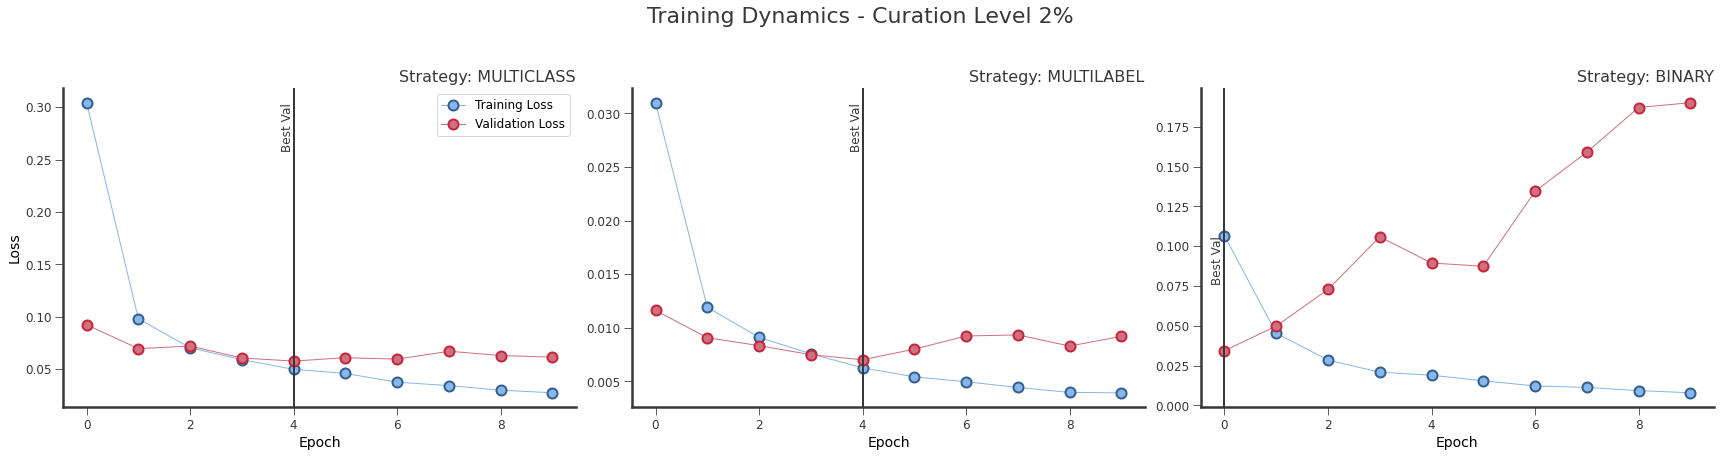

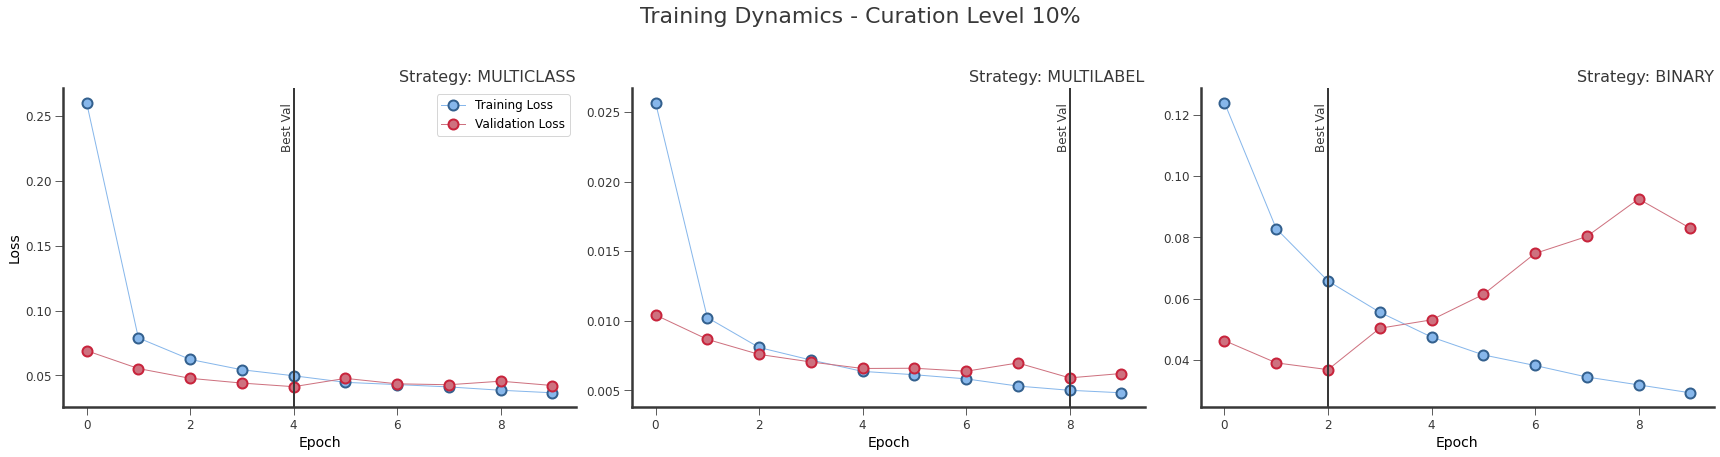

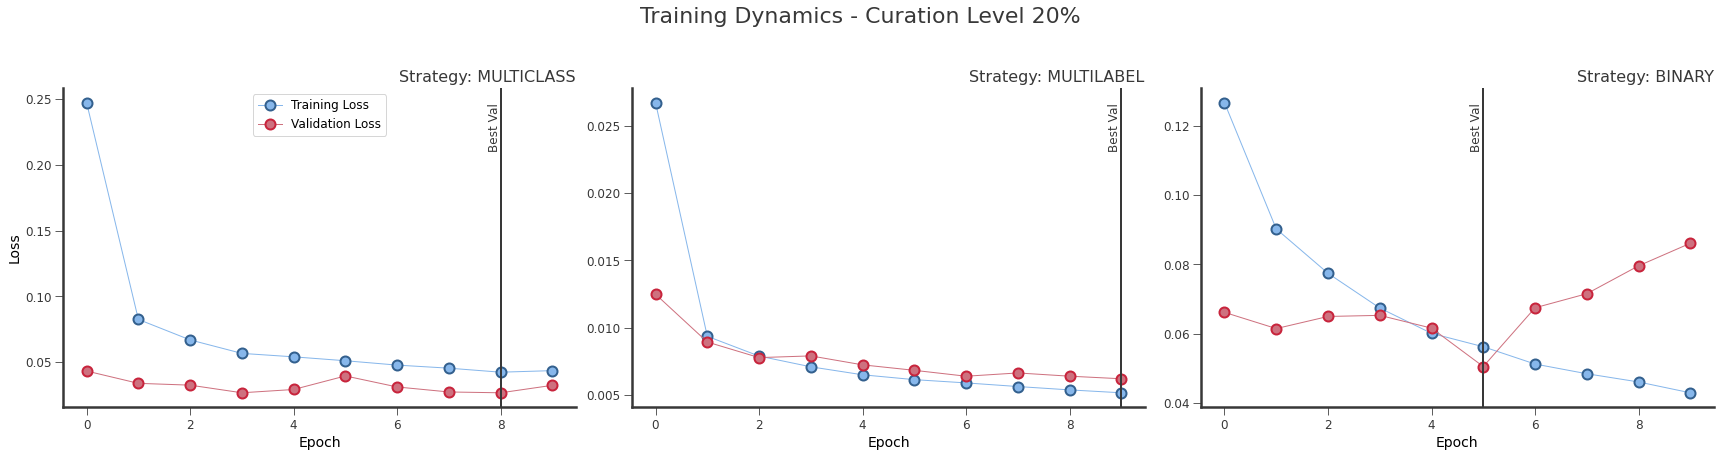

In [21]:
# Configuration
strategies = ["multiclass", "multilabel", "binary"]
curation_levels = ["2", "10", "20"]
num_epochs = 10

# Dictionary to store training history for plotting later
# Structure: history[level][strategy] = {'train': [], 'val': []}
training_history = {level: {strat: {'train': [], 'val': []} for strat in strategies} for level in curation_levels}

print("=== Starting Multi-Level Curation Strategy Experiments ===")

for level in curation_levels:
    print(f"\n\n CURATION LEVEL: {level}%")
    
    # 1. Create Checkpoint Directory for this level
    # e.g. ./checkpoints/level_20/
    level_ckpt_folder = os.path.join(os.getcwd(), 'checkpoints', f'level_{level}')
    os.makedirs(level_ckpt_folder, exist_ok=True)
    
    # 2. Retrieve the correct IDK sets for this level
    current_idk_train = idk_train[level]
    current_idk_val = idk_val[level]
    
    for strat in strategies:
        print(f"\n   Training Strategy: {strat.upper()}")
        
        # 3. Create Datasets
        train_ds = CurationStrategyDataset(train_dataset, current_idk_train, mode=strat, transforms=image_transforms)
        val_ds = CurationStrategyDataset(val_dataset, current_idk_val, mode=strat, transforms=image_transforms)
        
        # 4. Weighted Sampler (Crucial for class balance)
        sampler = get_weighted_sampler_optimized(train_ds)
        
        # 5. DataLoaders
        # Note: Shuffle MUST be False when using a sampler
        t_loader = DataLoader(train_ds, batch_size=64, sampler=sampler, shuffle=False, num_workers=2)
        v_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
        
        # 6. Model Setup
        model = get_model(strat).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 7. Criterion (Dynamic Focal Loss)
        if strat == "binary":
            criterion = DynamicFocalLoss(num_classes=2, mode=strat, gamma=2.0, ema_alpha=0.9)
        else: # Multiclass or Multilabel
            criterion = DynamicFocalLoss(num_classes=11, mode=strat, gamma=2.0, ema_alpha=0.9)
            
        # 8. Training Loop
        best_loss = float('inf')
        train_losses_log = []
        val_losses_log = []
        
        for epoch in range(num_epochs):
            t_loss = train_epoch(model, t_loader, optimizer, criterion)
            v_loss = val_epoch(model, v_loader, criterion)
            
            # Store metrics
            train_losses_log.append(t_loss)
            val_losses_log.append(v_loss)
            
            print(f"      Epoch {epoch+1} | Train: {t_loss:.4f} | Val: {v_loss:.4f}")
            
            # Save Best Model
            if v_loss < best_loss:
                best_loss = v_loss
                save_path = os.path.join(level_ckpt_folder, f"best_{strat}.pth")
                torch.save(model.state_dict(), save_path)
                print(f"      --> Found better weights. Model saved.") #Saved to {save_path}")
        
        # Store history for this specific run
        training_history[level][strat]['train'] = train_losses_log
        training_history[level][strat]['val'] = val_losses_log

print("\n All Experiments Completed.")

# --- Generate Plots ---
plot_strategies_comparison(training_history, level="2")
plot_strategies_comparison(training_history, level="10")
plot_strategies_comparison(training_history, level="20")

In [72]:
class CurationComparator:
    """
    A dedicated class to compare different curation strategies (Baseline, Multiclass, Multilabel, Binary).
    Handles inference, evaluation against curated ground truth, and plotting.
    """
    def __init__(self, device, transforms):
        self.device = device
        self.transforms = transforms
        self.reports = {} # Stores classification reports

    def evaluate_model(self, strategy_name, model_path, fo_dataset, idk_ids, pred_field):
        """
        Evaluates a specific model strategy and stores the report.
        
        Args:
            strategy_name: "baseline", "multiclass", "multilabel", or "binary"
            model_path: Path to .pth file
            fo_dataset: FiftyOne dataset (Test set)
            idk_ids: Set of IDs flagged as IDK (for dataset wrapper)
            pred_field: Name of field to store predictions in
        """
        print(f"--- Evaluating Model: {strategy_name.upper()} ---")
        
        # 1. Setup Model & Dataset based on Strategy
        if strategy_name == "baseline":
            # Original LeNet (10 classes)
            model = ModernLeNet5(num_classes=10).to(self.device)
            ds = CustomTorchImageDataset(fo_dataset, image_transforms=self.transforms)
            
        elif strategy_name == "binary":
            # 2 classes (Known vs IDK)
            model = ModernLeNet5(num_classes=2).to(self.device)
            ds = CurationStrategyDataset(fo_dataset, idk_ids, mode="binary", transforms=self.transforms)
            
        else:
            # Multiclass / Multilabel (11 classes)
            model = ModernLeNet5(num_classes=11).to(self.device)
            ds = CurationStrategyDataset(fo_dataset, idk_ids, mode=strategy_name, transforms=self.transforms)

        # Load Weights
        model.load_state_dict(torch.load(model_path))
        model.eval()
        
        loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2)
        preds_fo = []

        # 2. Inference Loop
        with torch.inference_mode():
            for data, _ in tqdm(loader, desc=f"Predicting {strategy_name}", leave=False):
                data = data.to(self.device)
                logits = model(data)

                if strategy_name == "baseline" or strategy_name == "multiclass":
                    # Standard Softmax
                    probs = F.softmax(logits, dim=1)
                    conf, pred_idx = torch.max(probs, 1)
                    for i in range(len(pred_idx)):
                        preds_fo.append(fo.Classification(label=str(pred_idx[i].item()), confidence=conf[i].item()))

                elif strategy_name == "multilabel":
                    # Sigmoid
                    probs = torch.sigmoid(logits)
                    probs_np = probs.cpu().numpy()
                    for i in range(len(probs_np)):
                        am = np.argmax(probs_np[i])
                        preds_fo.append(fo.Classification(label=str(am), confidence=float(probs_np[i][am])))

                elif strategy_name == "binary":
                    # Map 1 -> "10" (IDK), 0 -> "0" (Placeholder for Known)
                    probs = F.softmax(logits, dim=1)
                    conf, pred_idx = torch.max(probs, 1)
                    for i in range(len(pred_idx)):
                        lbl = "10" if pred_idx[i].item() == 1 else "0"
                        preds_fo.append(fo.Classification(label=lbl, confidence=conf[i].item()))

        # 3. Store Predictions
        fo_dataset.set_values(pred_field, preds_fo)

        # 4. Run Evaluation (Against 0-10 Curated GT)
        target_classes = [str(i) for i in range(11)]
        
        # Delete existing evaluation if it exists ---
        eval_key = f"eval_{strategy_name}"
        if eval_key in fo_dataset.list_evaluations():
            print(f"   Deleting existing evaluation '{eval_key}' to overwrite...")
            fo_dataset.delete_evaluation(eval_key)
        
        results = fo_dataset.evaluate_classifications(
            pred_field,
            gt_field="curated_gt",
            eval_key=eval_key,
            method="simple",
            classes=target_classes
        )
        
        self.reports[strategy_name] = results.report()
        print(f"{strategy_name} evaluation complete.")

    def plot_f1_comparison(self):
        """
        Plots grouped bar chart comparing Baseline vs Multiclass vs Multilabel.
        Adds Binary IDK performance as a reference line.
        """
        print("--- Plotting F1 Score Comparison ---")
        classes = [str(i) for i in range(11)]
        x = np.arange(len(classes))
        width = 0.25

        plt.figure(figsize=(14, 7))

        # Strategies to plot as bars
        # (Key, Offset, Color, Label)
        bar_configs = [
            ("baseline", -1, "gray", "Baseline (Original)"),
            ("multiclass", 0, "skyblue", "Multiclass (Dynamic)"),
            ("multilabel", 1, "lightgreen", "Multilabel (Dynamic)"),
        ]

        for key, offset, color, lbl in bar_configs:
            if key in self.reports:
                # Get F1 per class, default 0 if missing
                scores = [self.reports[key].get(c, {'f1-score': 0})['f1-score'] for c in classes]
                plt.bar(x + offset*width, scores, width, label=lbl, color=color, edgecolor='black')

        # Binary Strategy (Only valid for IDK class)
        if "binary" in self.reports:
            bin_idk = self.reports['binary'].get("10", {'f1-score': 0})['f1-score']
            plt.axhline(y=bin_idk, color='salmon', linestyle='--', linewidth=2, label=f'Binary IDK ({bin_idk:.3f})')
            # Annotate line
            plt.text(10, bin_idk + 0.02, f"{bin_idk:.2f}", color='salmon', fontweight='bold', ha='right')

        plt.xlabel("Class Label (0-9 = Digits, 10 = IDK)", fontsize=12)
        plt.ylabel("F1 Score", fontsize=12)
        plt.title("Impact of Curation Strategies on Model Performance", fontsize=14)
        plt.xticks(x, labels=["0","1","2","3","4","5","6","7","8","9","IDK (10)"])
        plt.ylim(0.0, 1.05)
        plt.legend(loc='lower left')
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

--- Evaluating Model: BASELINE ---


   Deleting existing evaluation 'eval_baseline' to overwrite...
baseline evaluation complete.
--- Evaluating Model: MULTICLASS ---


   Deleting existing evaluation 'eval_multiclass' to overwrite...
multiclass evaluation complete.
--- Evaluating Model: MULTILABEL ---


   Deleting existing evaluation 'eval_multilabel' to overwrite...
multilabel evaluation complete.
--- Evaluating Model: BINARY ---


   Deleting existing evaluation 'eval_binary' to overwrite...
binary evaluation complete.
--- Plotting F1 Score Comparison ---


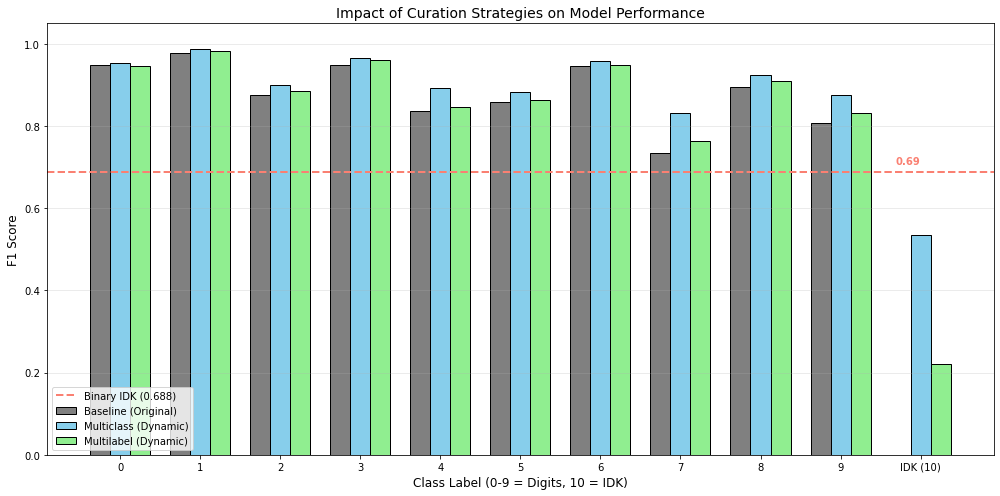

In [73]:
# 1. Instantiate the Comparator
comparator = CurationComparator(device, image_transforms)

# 2. Evaluate Baseline (Original LeNet)
# Uses the original checkpoint
comparator.evaluate_model(
    "baseline", 
    f"{checkpoint_folder}/best_lenet.pth", 
    test_dataset, 
    idk_test_ids, 
    "pred_baseline"
)

# 3. Evaluate Dynamic Multiclass
# Uses result from Dynamic Focal Loss training
comparator.evaluate_model(
    "multiclass", 
    f"{checkpoint_folder}/best_multiclass.pth", 
    test_dataset, 
    idk_test_ids, 
    "pred_mc_dyn"
)

# 4. Evaluate Dynamic Multilabel
comparator.evaluate_model(
    "multilabel", 
    f"{checkpoint_folder}/best_multilabel.pth", 
    test_dataset, 
    idk_test_ids, 
    "pred_ml_dyn"
)

# 5. Evaluate Dynamic Binary
comparator.evaluate_model(
    "binary", 
    f"{checkpoint_folder}/best_binary.pth", 
    test_dataset, 
    idk_test_ids, 
    "pred_bin_dyn"
)

# 6. Plot the 4-way Comparison
comparator.plot_f1_comparison()

# Part X: Save the Curated MNIST to the Hard Drive to upload it on HuggingFace 

In [22]:
# We list the datasets that we have available on this session.
fo.list_datasets()

['mnist-curation-lab-test',
 'mnist-curation-lab-tv',
 'mnist-test-run',
 'mnist-test-set',
 'mnist-train-run',
 'mnist-training-set',
 'mnist-validation-set']

In [ ]:
# Load the three separate datasets
train_dataset = fo.load_dataset("mnist-training-set")
val_dataset = fo.load_dataset("mnist-validation-set")
test_dataset = fo.load_dataset("mnist-test-set")

# Create a new merged dataset
merged_dataset = fo.Dataset("curated-mnist")

# Add training samples with split tag
for sample in train_dataset:
    sample.tags.append("train")
    merged_dataset.add_sample(sample)

# Add validation samples with split tag
for sample in val_dataset:
    sample.tags.append("validation")
    merged_dataset.add_sample(sample)

# Add test samples with split tag
for sample in test_dataset:
    sample.tags.append("test")
    merged_dataset.add_sample(sample)

# Save the merged dataset
merged_dataset.persistent = True

print(f"Merged dataset created with {len(merged_dataset)} total samples")
print(f"Train samples: {len(merged_dataset.match_tags('train'))}")
print(f"Validation samples: {len(merged_dataset.match_tags('validation'))}")
print(f"Test samples: {len(merged_dataset.match_tags('test'))}")

In [ ]:
# Save merged_dataset to disk using FiftyOneDataset type
export_dir = Path.cwd() / "Classification" / "curated_mnist_fiftyone"
export_dir.mkdir(parents=True, exist_ok=True)

merged_dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True  # This exports the actual image files along with metadata
)

print(f"Merged dataset exported to: {export_dir}")
print(f"Total samples exported: {len(merged_dataset)}")